In [13]:
import pickle
import os
import numpy as np
from nltk import ngrams
from sklearn.metrics import accuracy_score
import math
import blosum as bl
import torch
from torcheval.metrics.text import Perplexity
import decimal
import statistics
import platform
import matplotlib.pyplot as plt
# desired precision for printing float values
#decimal.getcontext().prec = 18
query = "PF00959"
directory_path = 'after_50/'#'results_noGit/results_after_Fine_tuning/' 
experiments = os.listdir(directory_path)
with open('mapping_files/aa_to_ctrl_idx.p','rb') as handle:
    aa_to_ctrl_idx = pickle.load(handle)
vocab_loc = 'mapping_files/vocab.txt'
use_py3 = platform.python_version()[0] == '3'
vocab = open(vocab_loc).readlines() if not use_py3 else open(vocab_loc, encoding='utf-8').read().split('\n')[:-1]
vocab = list(map(lambda x: x.split(' ')[0], vocab))
vocab_size = len(vocab)

after_training_experiments = os.listdir(directory_path + '')

print(experiments)
print('-----')
print(after_training_experiments)

['PF00959_generalModel_after_50_proteins_2000_p_0_k_1_key_only_0']
-----
['PF00959_generalModel_after_50_proteins_2000_p_0_k_1_key_only_0']


<p>To evaluate the generated sequence using teacher forcing:

1. Generate the Sequence: The transformer model with teacher forcing generates the complete sequence. 
At each time step, we provide the true input sequence (+ 1 versus previous step), as input to the model.

2. Calculate Metrics: Accuracy, soft accuracy (based on BLOSUM matrix), perplexity. 

</p>

In [3]:
#  BLOSUM62 is the matrix built using sequences with less than 62% similarity 
# (sequences with ≥ 62% identity were clustered)

def compute_hard_accuracy(true_string, predicted_string):
    # percentage of predictions that exactly match the ground truth labels
    total_characters = len(true_string)
    assert total_characters == len(predicted_string)
    # Convert strings to lists of characters
    true_list = list(true_string)
    predicted_list = list(predicted_string)
    # Compute hard accuracy using accuracy_score function
    hard_accuracy = accuracy_score(true_list, predicted_list)
    return hard_accuracy

def compute_all_hard_accuracies(true_sequences, predicted_sequences):
    num_seq = len(true_sequences)
    assert num_seq == len(predicted_sequences)
    accuracy_all = []
    accuracy_dict = {}
    accuracy_512 = []
    for i in range(0, 8000, 50):
        accuracy_dict[i] = []
    for i in range(num_seq):
        sequence = true_sequences[i]
        predicted_sequence = predicted_sequences[i]
        tmp_acc = compute_hard_accuracy(sequence, predicted_sequence)
        accuracy_all.append(tmp_acc)
        for j in range(0, len(sequence)-49, 50):
            tmp_acc_ranges = compute_hard_accuracy(sequence[j:j+50], predicted_sequence[j:j+50])
            accuracy_dict[j].append(float(tmp_acc_ranges))
            
        # results for size max 512
        if len(sequence) >= 512:
            tmp_acc_512 = compute_hard_accuracy(sequence[:512], predicted_sequence[:512])
        else:
            tmp_acc_512 = tmp_acc
        accuracy_512.append(tmp_acc_512)
    # fuori dal for:
    result_512 = sum(accuracy_512) / num_seq
    st_deviation_512 = np.std(accuracy_512)
    result_512 = (float(result_512), float(st_deviation_512))
    
    
    result = sum(accuracy_all) / num_seq
    for key in accuracy_dict:
        if len(accuracy_dict[key]) <= 0:
            break
        if len(accuracy_dict[key]) < 2:
            accuracy_dict[key] = (sum(accuracy_dict[key])/len(accuracy_dict[key]), 0.0)
        else:
            accuracy_dict[key] = (sum(accuracy_dict[key])/len(accuracy_dict[key]), statistics.stdev(accuracy_dict[key]))
    st_deviation = statistics.stdev(accuracy_all)
    result = (result, st_deviation)
    return result, result_512, accuracy_dict

def compute_soft_accuracies(true_sequences, predicted_sequences, threshold = 0):
    # soft accuracy takes into account partial matches or similarities 
    # between the predictions and the ground truth labels
    bl_matrix = bl.BLOSUM(62)
    num_seq = len(true_sequences)
    assert num_seq == len(predicted_sequences)
    accuracy_all = []
    accuracy_dict = {}
    accuracy_512 = []
    for i in range(0, 8000, 50):
        accuracy_dict[i] = []
    for i in range(num_seq):
        sequence = true_sequences[i]
        predicted_sequence = predicted_sequences[i]
        tmp_acc = calculate_soft_accuracy(sequence, predicted_sequence, bl_matrix, threshold)
        accuracy_all.append(tmp_acc)
        for j in range(0, len(sequence)-49, 50):
            tmp_acc_ranges = calculate_soft_accuracy(sequence[j:j+50], predicted_sequence[j:j+50], bl_matrix, threshold)
            accuracy_dict[j].append(tmp_acc_ranges) 
        # results for size max 512
        if len(sequence) >= 512:
            tmp_sacc_512 = calculate_soft_accuracy(sequence[:512], predicted_sequence[:512], bl_matrix, threshold)
        else:
            tmp_sacc_512 = tmp_acc
        accuracy_512.append(tmp_sacc_512)
    # fuori dal for:
    result_512 = sum(accuracy_512) / num_seq
    st_deviation_512 = np.std(accuracy_512)
    result_512 = (float(result_512), float(st_deviation_512))
    
    
    result = sum(accuracy_all) / num_seq
    for key in accuracy_dict:
        if len(accuracy_dict[key]) <= 0:
            break
        if len(accuracy_dict[key]) < 2:
            accuracy_dict[key] = (sum(accuracy_dict[key])/len(accuracy_dict[key]), 0.0)
        else:
            accuracy_dict[key] = (sum(accuracy_dict[key])/len(accuracy_dict[key]), statistics.stdev(accuracy_dict[key]))
    st_deviation = statistics.stdev(accuracy_all)
    result = (result, st_deviation)
    return result, result_512, accuracy_dict

def calculate_soft_accuracy(true_sequence, predicted_sequence, bl_matrix, threshold = 0):
    total_characters = len(true_sequence)
    assert total_characters == len(predicted_sequence)
    partial_matches = 0
    for true_aa, predicted_aa in zip(true_sequence, predicted_sequence):
        similarity_score = bl_matrix[true_aa][predicted_aa]
        if similarity_score >= threshold:
            partial_matches += 1
    soft_accuracy = partial_matches / total_characters
    return soft_accuracy


def compute_perplexity_new(probs, indexes):
    ppls = []  # List to store perplexity for each sequence in the batch
    with torch.no_grad():
        for sample_i in range(probs.shape[0]):  # Each sample in batch
            y_pred, y_actual = probs[sample_i], indexes[sample_i]

            # Apply softmax along the class dimension (assuming it's not applied yet)
            y_pred = torch.nn.functional.softmax(y_pred, dim=1)

            # Compute log probability of the true labels
            ent = torch.log(y_pred[range(y_pred.shape[0]), y_actual])

            # Compute average negative log likelihood
            avg_nll = -torch.mean(ent)

            # Compute perplexity
            ppl = torch.exp(avg_nll).item()
            ppls.append(ppl)

    # Compute average perplexity across the batch
    avg_perplexity = sum(ppls) / len(ppls)
    return avg_perplexity



def compute_perplexity(probs, true_sequence): 
    true_sequence_ctrl_codes = [aa_to_ctrl_idx[code]-vocab_size+26 for code in true_sequence]
    #print('true_sequence_ctrl_codes: ', true_sequence_ctrl_codes)
    indexes_new = torch.tensor(true_sequence_ctrl_codes).view(1, len(true_sequence_ctrl_codes))
    #print('indexes_new: ', indexes_new)
    #print('indexes_new sh: ', indexes_new.shape)
    probs_new = probs.unsqueeze(0)  # new shape will be torch.Size([1, 149, 1, 25])
    #print('probs_new 1: ', probs_new)
    #print('probs_new 1 sh: ', probs_new.shape)
    # Removing the singleton dimension at position 2 (0-indexed)
    probs_new = probs_new.squeeze(2)  # new shape will be torch.Size([1, 149, 25])
    #print('probs_new 2 sh: ', probs_new.shape)
    metric = Perplexity()
    input_p = probs_new
    target = indexes_new
    metric.update(input_p, target)
    perplexity = metric.compute()
    
    #print("new ppx: ", compute_perplexity_new(probs_new, indexes_new))
    #print("my ppx: ", perplexity)
    
    
    #print("probs.shape: ", probs.shape)
    #print("indexes.shape: ", indexes.shape)
    #print("probs: ", probs)
    #print("indexes: ", indexes)
    return perplexity

def compute_perplexities(probs_all, true_sequences_all):
    num_seq = len(true_sequences_all)
    """try:
        indexes_all[0][0][0]
    except TypeError: 
        indexes = torch.tensor(indexes_all)
        probs = torch.tensor(probs_all)
        tmp_perplexity = compute_perplexity(probs, indexes)
        return tmp_perplexity
    """
    assert num_seq == len(probs_all)
    perplexity_all = []
    perplexity_512 = []
    perplexity_dict = {}
    for i in range(0, 8000, 50):
        perplexity_dict[i] = []
    for i in range(num_seq):
        true_sequence = true_sequences_all[i]
        true_sequence = true_sequence[1:]
        probs = torch.tensor(probs_all[i])
        tmp_perplexity = compute_perplexity(probs, true_sequence)
        perplexity_all.append(tmp_perplexity)
        for j in range(0, len(true_sequence)-49, 50):
            tmp_per = compute_perplexity(probs[j:j+50], true_sequence[j:j+50])
            perplexity_dict[j].append(tmp_per)  
        
        # results for size max 512
        if len(probs) >= 512:
            tmp_perp_512 = compute_perplexity(probs[:512], true_sequence[:512])
        else:
            tmp_perp_512 = tmp_perplexity
        perplexity_512.append(tmp_perp_512)
    # fuori dal for:
    result_512 = sum(perplexity_512) / num_seq
    st_deviation_512 = np.std(perplexity_512)
    result_512 = (float(result_512), float(st_deviation_512))
    
    
    result = sum(perplexity_all) / num_seq
    for key in perplexity_dict:
        if len(perplexity_dict[key]) <= 0:
            break
        if len(perplexity_dict[key]) < 2:
            perplexity_dict[key] = (float(sum(perplexity_dict[key])/len(perplexity_dict[key])), 0.0)
        else:
            perplexity_dict[key] = (float(sum(perplexity_dict[key])/len(perplexity_dict[key])), np.std(perplexity_dict[key]))
    st_deviation = np.std(perplexity_all) # OR np.std
    result = (float(result), float(st_deviation))
    return result, result_512, perplexity_dict

In [31]:
# 0 if teacher forcing, n-1 if after-n
OFFSET = 49
MAX_LEN = 511
def compute_stats(data_dir):
    # paths to the saved .p files
    if os.path.exists(os.path.join(data_dir, "predicted_data.p")):
        predicted_data_file = os.path.join(data_dir, "predicted_data.p")
        true_data_file = os.path.join(data_dir, "true_data.p")
        indexes_all_data_file = os.path.join(data_dir, "true_tokens_index_data.p")
        probs_all_data_file = os.path.join(data_dir, "tokens_probs_data.p")
    else:
        predicted_data_file = os.path.join(data_dir, "predicted_data_" + query + ".p")
        true_data_file = os.path.join(data_dir, "true_data_" + query + ".p")
        indexes_all_data_file = os.path.join(data_dir, "true_tokens_index_data_" + query + ".p")
        probs_all_data_file = os.path.join(data_dir, "tokens_probs_data_" + query + ".p")
    
    # Reload predicted_data from the .p file
    predicted_data = False
    with open(predicted_data_file, "rb") as file:
        predicted_data = pickle.load(file)

    # Reload true_data from the .p file
    true_data = False
    with open(true_data_file, "rb") as file:
        true_data = pickle.load(file)

    # Reload probs_all_data from the .p file
    probs_all_data = False
    with open(probs_all_data_file, "rb") as file:
        probs_all_data = pickle.load(file)

    # Reload indexes_all_data from the .p file
    indexes_all_data = False
    with open(indexes_all_data_file, "rb") as file:
        indexes_all_data = pickle.load(file)
    indices_to_remove = []
    for i in range(len(predicted_data)):
        predicted_data[i] = predicted_data[i][OFFSET:MAX_LEN]
        true_data[i] = true_data[i][OFFSET:MAX_LEN]
        probs_all_data[i] = probs_all_data[i][:MAX_LEN - OFFSET]
        #print(predicted_data[i])
        #print(true_data[i])
        if len(probs_all_data[i])==511:
            # print('case 1')
            offset = 511 - 1
            probs_all_data[i] = probs_all_data[i][:offset]
        elif len(probs_all_data[i]) == len(true_data[i]):
            # print('case 2')
            offset = len(true_data[i]) - 1
            probs_all_data[i] = probs_all_data[i][:offset]
        #print('probs: ', len(probs_all_data[i]))
        #print('true_sequence: ', len(true_data[i]))
        #print('predicted_data: ', len(predicted_data[i]))
        if len(true_data[i]) <= 1:
            indices_to_remove.append(i)
    for index in sorted(indices_to_remove, reverse=True):
        del predicted_data[index]
        del true_data[index]
        del probs_all_data[index]
    #true_data = [x for x in true_data if x is not None and x != 'NaN']

    # Compute hard accuracy
    accuracy, accuracy_512, accuracy_dict = compute_all_hard_accuracies(true_data, predicted_data)

    # Compute perplexity
    perplexity, perplexity_512, perplexity_dict = compute_perplexities(probs_all_data, true_data)

    # Compute soft accuracy
    soft_accuracy, soft_accuracy_512, soft_accuracy_dict = compute_soft_accuracies(true_data, predicted_data)

    results = " & $" + str(round(accuracy[0]*100, 3)) + "$/$" + str(round(accuracy[1]*100, 3)) + "$ & $"
    results += str(round(soft_accuracy[0]*100, 3)) + "$/$" + str(round(soft_accuracy[1]*100, 3)) + "$ & $" 
    results += str(round(perplexity[0], 3)) + "$/$" + str(round(perplexity[1], 3)) + "$ "
    
    results_512 = " & $" + str(round(accuracy_512[0]*100, 3)) + "$/$" + str(round(accuracy_512[1]*100, 3)) + "$ & $"
    results_512 += str(round(soft_accuracy_512[0]*100, 3)) + "$/$" + str(round(soft_accuracy_512[1]*100, 3)) + "$ & $" 
    results_512 += str(round(perplexity_512[0], 3)) + "$/$" + str(round(perplexity_512[1], 3)) + "$ "
    #print("\n\nAccuracy dict:", accuracy_dict, "\n\nSoft accuracy dict:", 
    #      soft_accuracy_dict, "\n\nPerplexity dict: ", perplexity_dict)
    return results, results_512, accuracy_dict, soft_accuracy_dict, perplexity_dict

In [15]:
def stats_graphs(accur_dict, soft_accur_dict, perplex_dict, name):
    # Filter out the empty values for perplexity
    x_values_perplexity = ['['+str(x+1)+'-'+str(x+50)+']' for x in accur_dict.keys() if perplex_dict[x]]
    
    perplexity_stds = [perplex_dict[x][1] for x in accur_dict.keys() if perplex_dict[x]]
    perplexity_values = [perplex_dict[x][0] for x in accur_dict.keys() if perplex_dict[x]]

    # Plot accuracy and soft accuracy on one graph
    plt.figure(figsize=(10, 6), dpi=400)

    plt.plot(x_values_perplexity, perplexity_values, label='Perplexity', color=(70/255, 163/255, 139/255), antialiased=True)
    
    plt.fill_between(x_values_perplexity, np.array(perplexity_values) - np.array(perplexity_stds), 
                     np.array(perplexity_values) + np.array(perplexity_stds), alpha=0.2, color=(70/255, 163/255, 139/255))

    # Set labels and title
    plt.xlabel('Range', fontsize=13)
    plt.ylabel('Perplexity', fontsize=13)
    plt.title('Perplexity over ranges', fontsize=15)
    plt.legend()

    plt.ylim(6, 27)  # Set ylim to ensure zero is within the range
    plt.xlim(-0.2, 8.2)  # Set xlim to ensure zero is within the range

    # Show the plot
    plt.grid(True, color=(0.8, 0.8, 0.8))
    plt.savefig(name + '_perplexity.svg')
    plt.show()

    # Create lists for x-axis and corresponding values for each dictionary
    # Filter out the empty values    
    
    x_values = ['['+str(x+1)+'-'+str(x+50)+']' for x in accur_dict.keys() if accur_dict[x] and soft_accur_dict[x] and perplex_dict[x]]
    accuracy_values = [accur_dict[x][0] for x in accur_dict.keys() if accur_dict[x] and soft_accur_dict[x] and perplex_dict[x]]
    accuracy_stds = [accur_dict[x][1] for x in accur_dict.keys() if accur_dict[x] and soft_accur_dict[x] and perplex_dict[x]]
    soft_accuracy_values = [soft_accur_dict[x][0] for x in accur_dict.keys() if accur_dict[x] and soft_accur_dict[x] and perplex_dict[x]]
    soft_accuracy_stds = [soft_accur_dict[x][1] for x in accur_dict.keys() if accur_dict[x] and soft_accur_dict[x] and perplex_dict[x]]

    # Plot the data
    plt.figure(figsize=(10, 6), dpi=400)

    plt.plot(x_values, accuracy_values, label='Accuracy', antialiased=True, alpha=0.8, color=(15/255, 87/255, 176/255))
    plt.fill_between(x_values, np.array(accuracy_values) - np.array(accuracy_stds), 
                     np.array(accuracy_values) + np.array(accuracy_stds), alpha=0.2, color=(135/255, 176/255, 205/255))

    plt.plot(x_values, soft_accuracy_values, label='Soft Accuracy', antialiased=True, alpha=0.8, color=(160/255, 20/255, 55/255))
    plt.fill_between(x_values, np.array(soft_accuracy_values) - np.array(soft_accuracy_stds), 
                     np.array(soft_accuracy_values) + np.array(soft_accuracy_stds), alpha=0.2, color=(224/255, 148/255, 160/255))


    # Set labels and title
    plt.xlabel('Range', fontsize=13)
    plt.ylabel('Value', fontsize=13)
    plt.title('Accuracy and soft accuracy over ranges', fontsize=15)
    plt.legend()

    plt.ylim(0, 1.1)  # Set ylim to ensure zero is within the range
    plt.xlim(-0.2, 8.2)  # Set xlim to ensure zero is within the range

    # Show the plot
    plt.grid(True, color=(0.8, 0.8, 0.8))
    plt.savefig(name + '_accuracy.svg')
    plt.show()

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def stats_graphs_comparison(accur_dict, soft_accur_dict, perplex_dict, acc_dict_after_t, soft_acc_dict_after_t, perp_dict_after_t):
    # Prepare data for accuracy, soft accuracy, and perplexity before and after transformation
    accuracy_values_before = [accur_dict[x][0] for x in accur_dict.keys() if accur_dict[x]]
    accuracy_stds_before = [accur_dict[x][1] for x in accur_dict.keys() if accur_dict[x]]
    
    soft_accuracy_values_before = [soft_accur_dict[x][0] for x in soft_accur_dict.keys() if soft_accur_dict[x]]
    soft_accuracy_stds_before = [soft_accur_dict[x][1] for x in soft_accur_dict.keys() if soft_accur_dict[x]]
    
    perplexity_values_before = [perplex_dict[x][0] for x in perplex_dict.keys() if perplex_dict[x]]
    perplexity_stds_before = [perplex_dict[x][1] for x in perplex_dict.keys() if perplex_dict[x]]

    accuracy_values_after = [acc_dict_after_t[x][0] for x in acc_dict_after_t.keys() if acc_dict_after_t[x]]
    accuracy_stds_after = [acc_dict_after_t[x][1] for x in acc_dict_after_t.keys() if acc_dict_after_t[x]]
    
    soft_accuracy_values_after = [soft_acc_dict_after_t[x][0] for x in soft_acc_dict_after_t.keys() if soft_acc_dict_after_t[x]]
    soft_accuracy_stds_after = [soft_acc_dict_after_t[x][1] for x in soft_acc_dict_after_t.keys() if soft_acc_dict_after_t[x]]

    perplexity_values_after = [perp_dict_after_t[x][0] for x in perp_dict_after_t.keys() if perp_dict_after_t[x]]
    perplexity_stds_after = [perp_dict_after_t[x][1] for x in perp_dict_after_t.keys() if perp_dict_after_t[x]]

    #ACCURACY
    # Prepare x-axis values
    x_values = ['[' + str(x+1) + '-' + str(x+50) + ']' for x in accur_dict.keys() if accur_dict[x]]
    
    plt.figure(figsize=(10, 6), dpi=400)
    plt.plot(x_values, accuracy_values_before, label='Accuracy before fine-tuning', antialiased=True, alpha=0.9, color=(180/255, 43/255, 46/255))
    plt.fill_between(x_values, np.array(accuracy_values_before) - np.array(accuracy_stds_before), 
                     np.array(accuracy_values_before) + np.array(accuracy_stds_before), alpha=0.1, color=(180/255, 43/255, 46/255))
    plt.plot(x_values, accuracy_values_after, label='Accuracy after fine-tuning', antialiased=True, alpha=0.9, color=(0/255, 111/255, 57/255))
    plt.fill_between(x_values, np.array(accuracy_values_after) - np.array(accuracy_stds_after), 
                     np.array(accuracy_values_after) + np.array(accuracy_stds_after), alpha=0.1, color=(0/255, 111/255, 57/255))
    # Set labels and title
    plt.xlabel('Range', fontsize=13)
    plt.ylabel('Value', fontsize=13)
    plt.title('Accuracy comparison over ranges', fontsize=15)
    plt.legend()
    plt.ylim(0, 1.1)  # Set ylim to ensure zero is within the range
    plt.xlim(-0.2, 8.2)  # Set xlim to ensure zero is within the range
    # Show the plot
    plt.grid(True, color=(0.8, 0.8, 0.8))
    plt.savefig('COMPARISON' + '_accuracy.svg')
    plt.show()
    
    # SOFT ACCURACY
    # Prepare x-axis values
    x_values = ['[' + str(x+1) + '-' + str(x+50) + ']' for x in soft_accur_dict.keys() if soft_accur_dict[x]]
    
    plt.figure(figsize=(10, 6), dpi=400)
    plt.plot(x_values, soft_accuracy_values_before, label='Soft accuracy before fine-tuning', antialiased=True, alpha=0.9, color=(180/255, 43/255, 46/255))
    plt.fill_between(x_values, np.array(soft_accuracy_values_before) - np.array(soft_accuracy_stds_before), 
                     np.array(soft_accuracy_values_before) + np.array(soft_accuracy_stds_before), alpha=0.1, color=(180/255, 43/255, 46/255))
    plt.plot(x_values, soft_accuracy_values_after, label='Soft accuracy after fine-tuning', antialiased=True, alpha=0.9, color=(0/255, 111/255, 57/255))
    plt.fill_between(x_values, np.array(soft_accuracy_values_after) - np.array(soft_accuracy_stds_after), 
                     np.array(soft_accuracy_values_after) + np.array(soft_accuracy_stds_after), alpha=0.1, color=(0/255, 111/255, 57/255))
    # Set labels and title
    plt.xlabel('Range', fontsize=13)
    plt.ylabel('Value', fontsize=13)
    plt.title('Soft accuracy comparison over ranges', fontsize=15)
    plt.legend()
    plt.ylim(0, 1.1)  # Set ylim to ensure zero is within the range
    plt.xlim(-0.2, 8.2)  # Set xlim to ensure zero is within the range
    # Show the plot
    plt.grid(True, color=(0.8, 0.8, 0.8))
    plt.savefig('COMPARISON' + '_soft_accuracy.svg')
    plt.show()
    
    # PERPLEXITY
    # Prepare x-axis values
    x_values = ['[' + str(x+1) + '-' + str(x+50) + ']' for x in perplex_dict.keys() if perplex_dict[x]]
    
    plt.figure(figsize=(10, 6), dpi=400)
    plt.plot(x_values, perplexity_values_before, label='Perplexity before fine-tuning', antialiased=True, alpha=0.9, color=(180/255, 43/255, 46/255))
    plt.fill_between(x_values, np.array(perplexity_values_before) - np.array(perplexity_stds_before), 
                     np.array(perplexity_values_before) + np.array(perplexity_stds_before), alpha=0.1, color=(180/255, 43/255, 46/255))
    plt.plot(x_values, perplexity_values_after, label='Perplexity after fine-tuning', antialiased=True, alpha=0.9, color=(0/255, 111/255, 57/255))
    plt.fill_between(x_values, np.array(perplexity_values_after) - np.array(perplexity_stds_after), 
                     np.array(perplexity_values_after) + np.array(perplexity_stds_after), alpha=0.1, color=(0/255, 111/255, 57/255))
    # Set labels and title
    plt.xlabel('Range', fontsize=13)
    plt.ylabel('Value', fontsize=13)
    plt.title('Perplexity comparison over ranges', fontsize=15)
    plt.legend()
    plt.ylim(6, 27)  # Set ylim to ensure zero is within the range
    plt.xlim(-0.2, 8.2)  # Set xlim to ensure zero is within the range
    # Show the plot
    plt.grid(True, color=(0.8, 0.8, 0.8))
    plt.savefig('COMPARISON' + '_perplexity.svg')
    plt.show()

In [17]:
try: 
    experiments.pop(experiments.index(".ipynb_checkpoints"))
except:
    print('no checkpoints1')
try: 
    after_training_experiments.pop(after_training_experiments.index(".ipynb_checkpoints"))
except:
    print('no checkpoints2')
try:
    experiments.pop(experiments.index("training_output.txt"))
    experiments.pop(experiments.index("training_output_2.txt"))
    experiments.pop(experiments.index("training_output_3.txt"))
    experiments.pop(experiments.index("training_output_4.txt"))
except:
    print('no tr_output1')
try:
    after_training_experiments.pop(after_training_experiments.index("training_output.txt"))
    after_training_experiments.pop(after_training_experiments.index("training_output_2.txt"))
    after_training_experiments.pop(after_training_experiments.index("training_output_3.txt"))
    after_training_experiments.pop(after_training_experiments.index("training_output_4.txt"))
except:
    print('no tr_output1')

no checkpoints1
no checkpoints2
no tr_output1
no tr_output1


In [18]:
for i in experiments:
    print(i)

PF00959_generalModel_after_50_proteins_2000_p_0_k_1_key_only_0


In [19]:
for i in after_training_experiments:
    print(i)

PF00959_generalModel_after_50_proteins_2000_p_0_k_1_key_only_0


PF00959_generalModel_after_50_proteins_2000_p_0_k_1_key_only_0



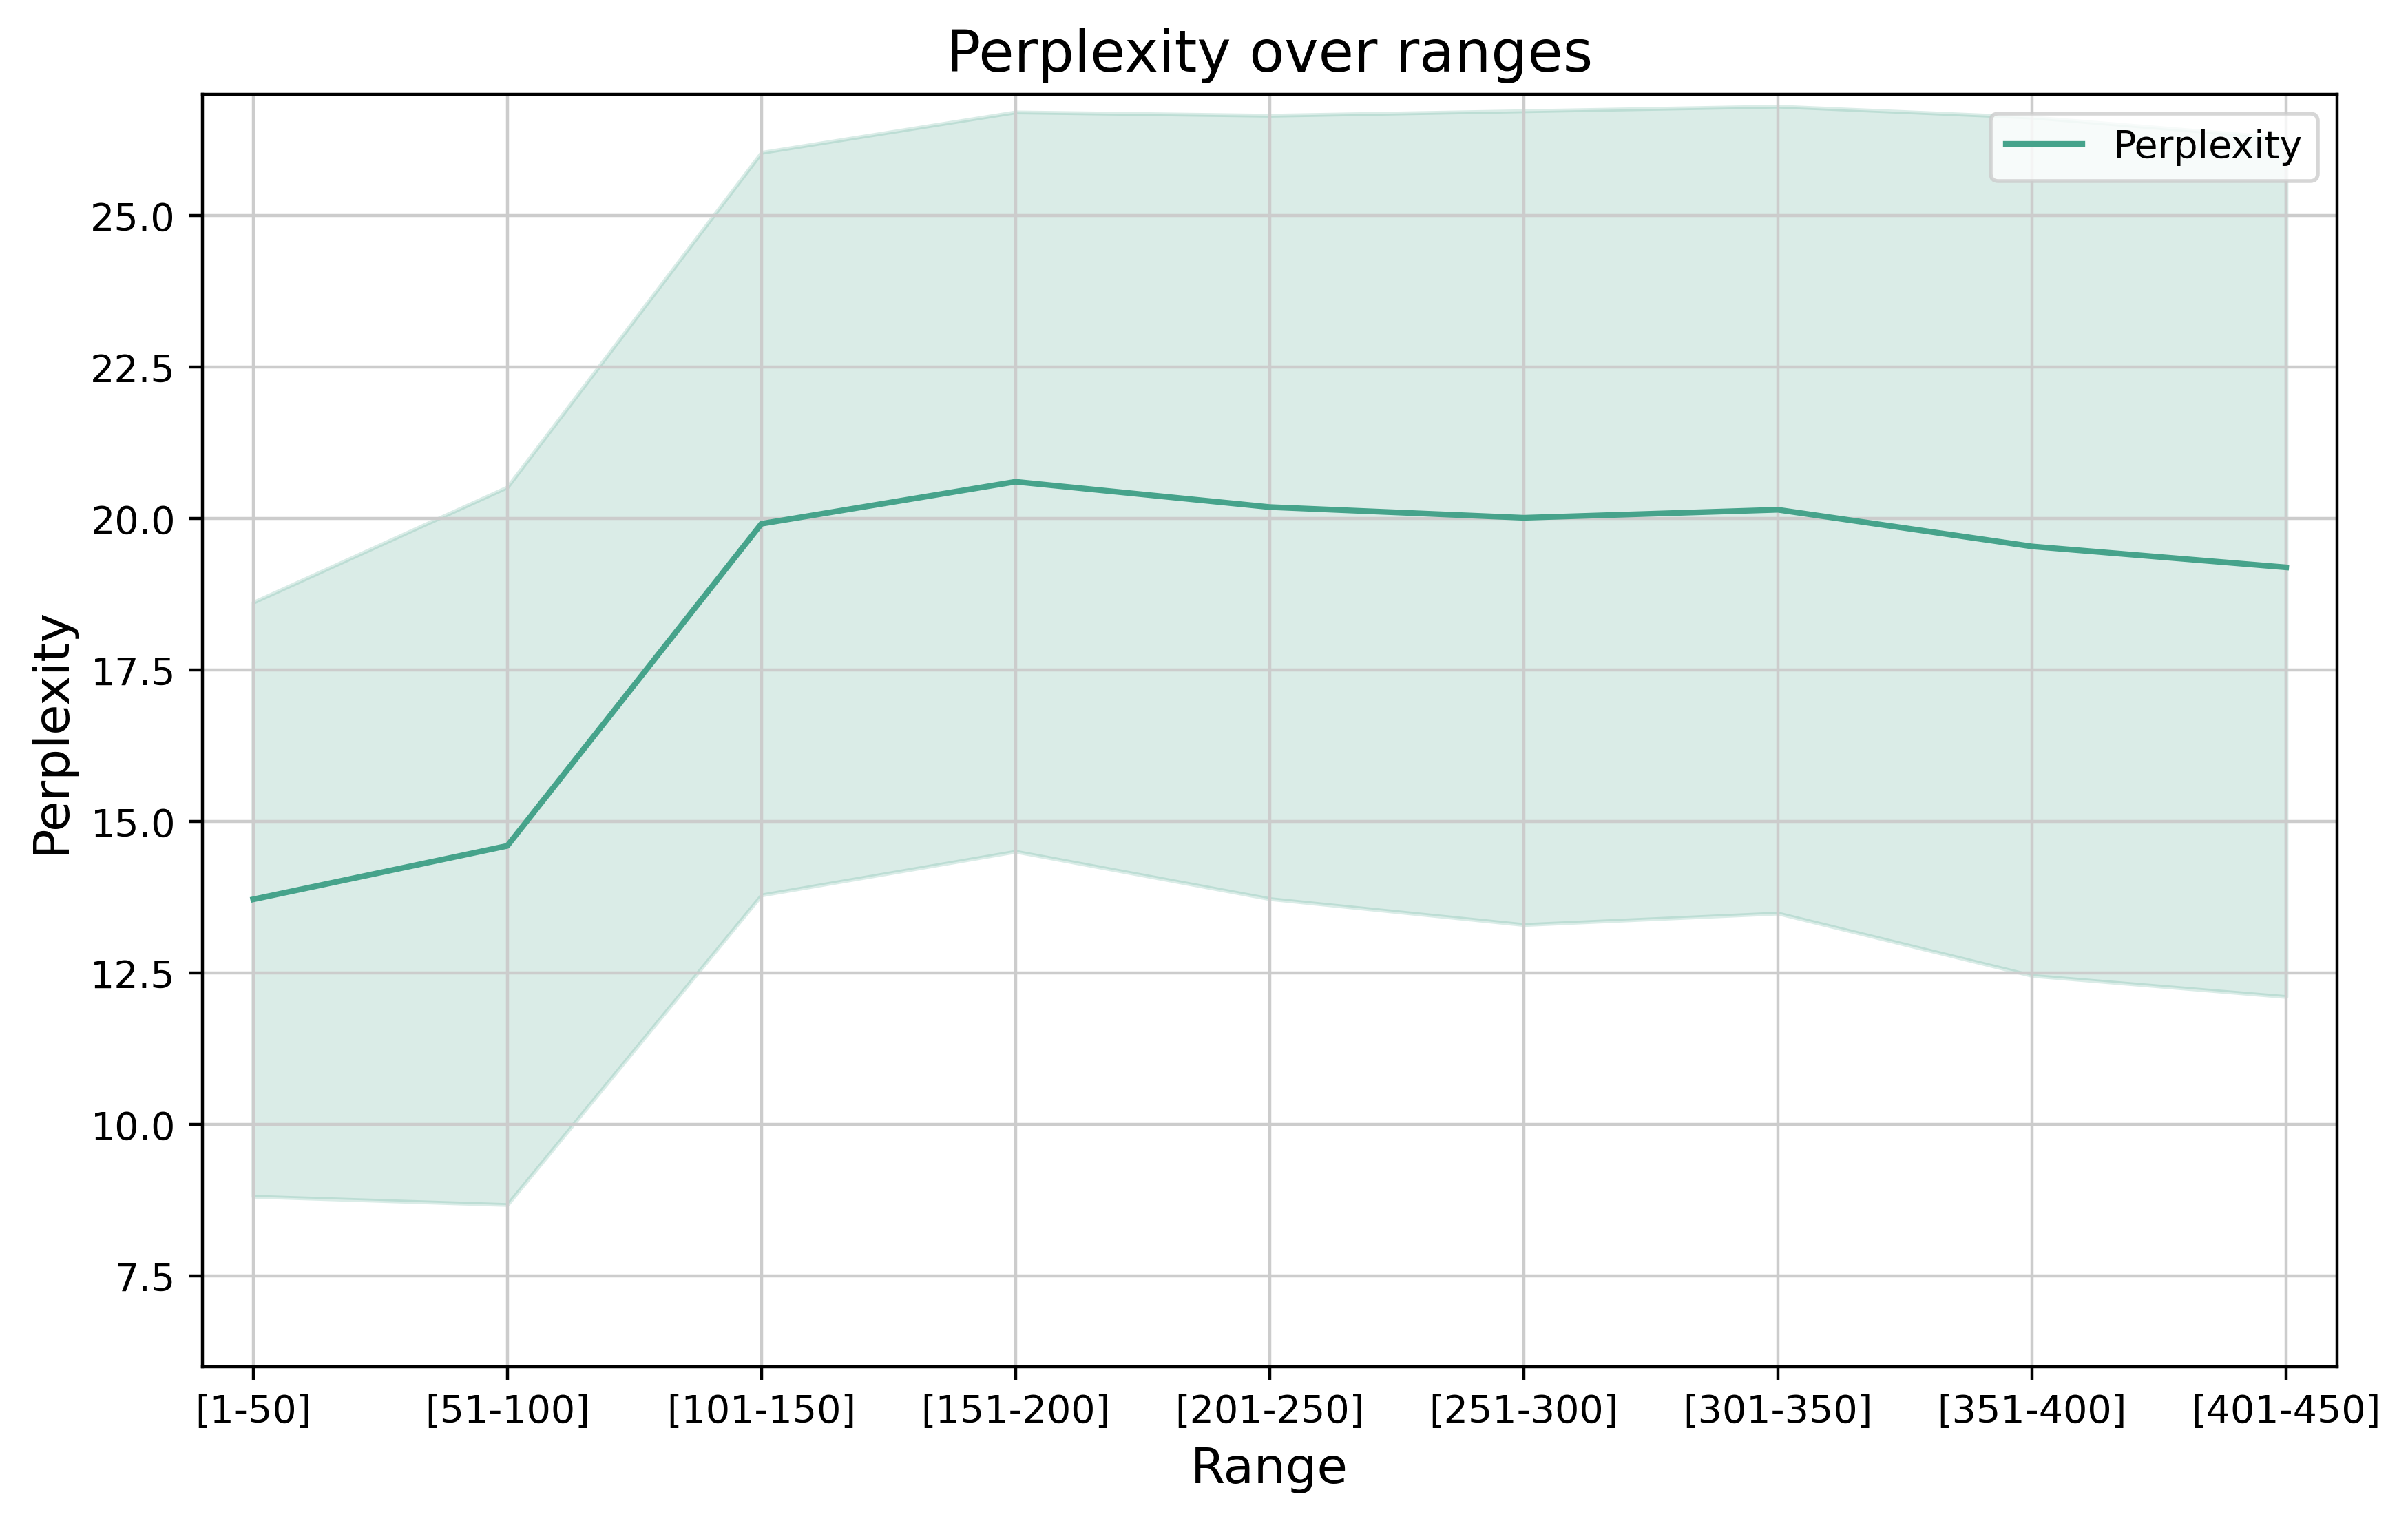

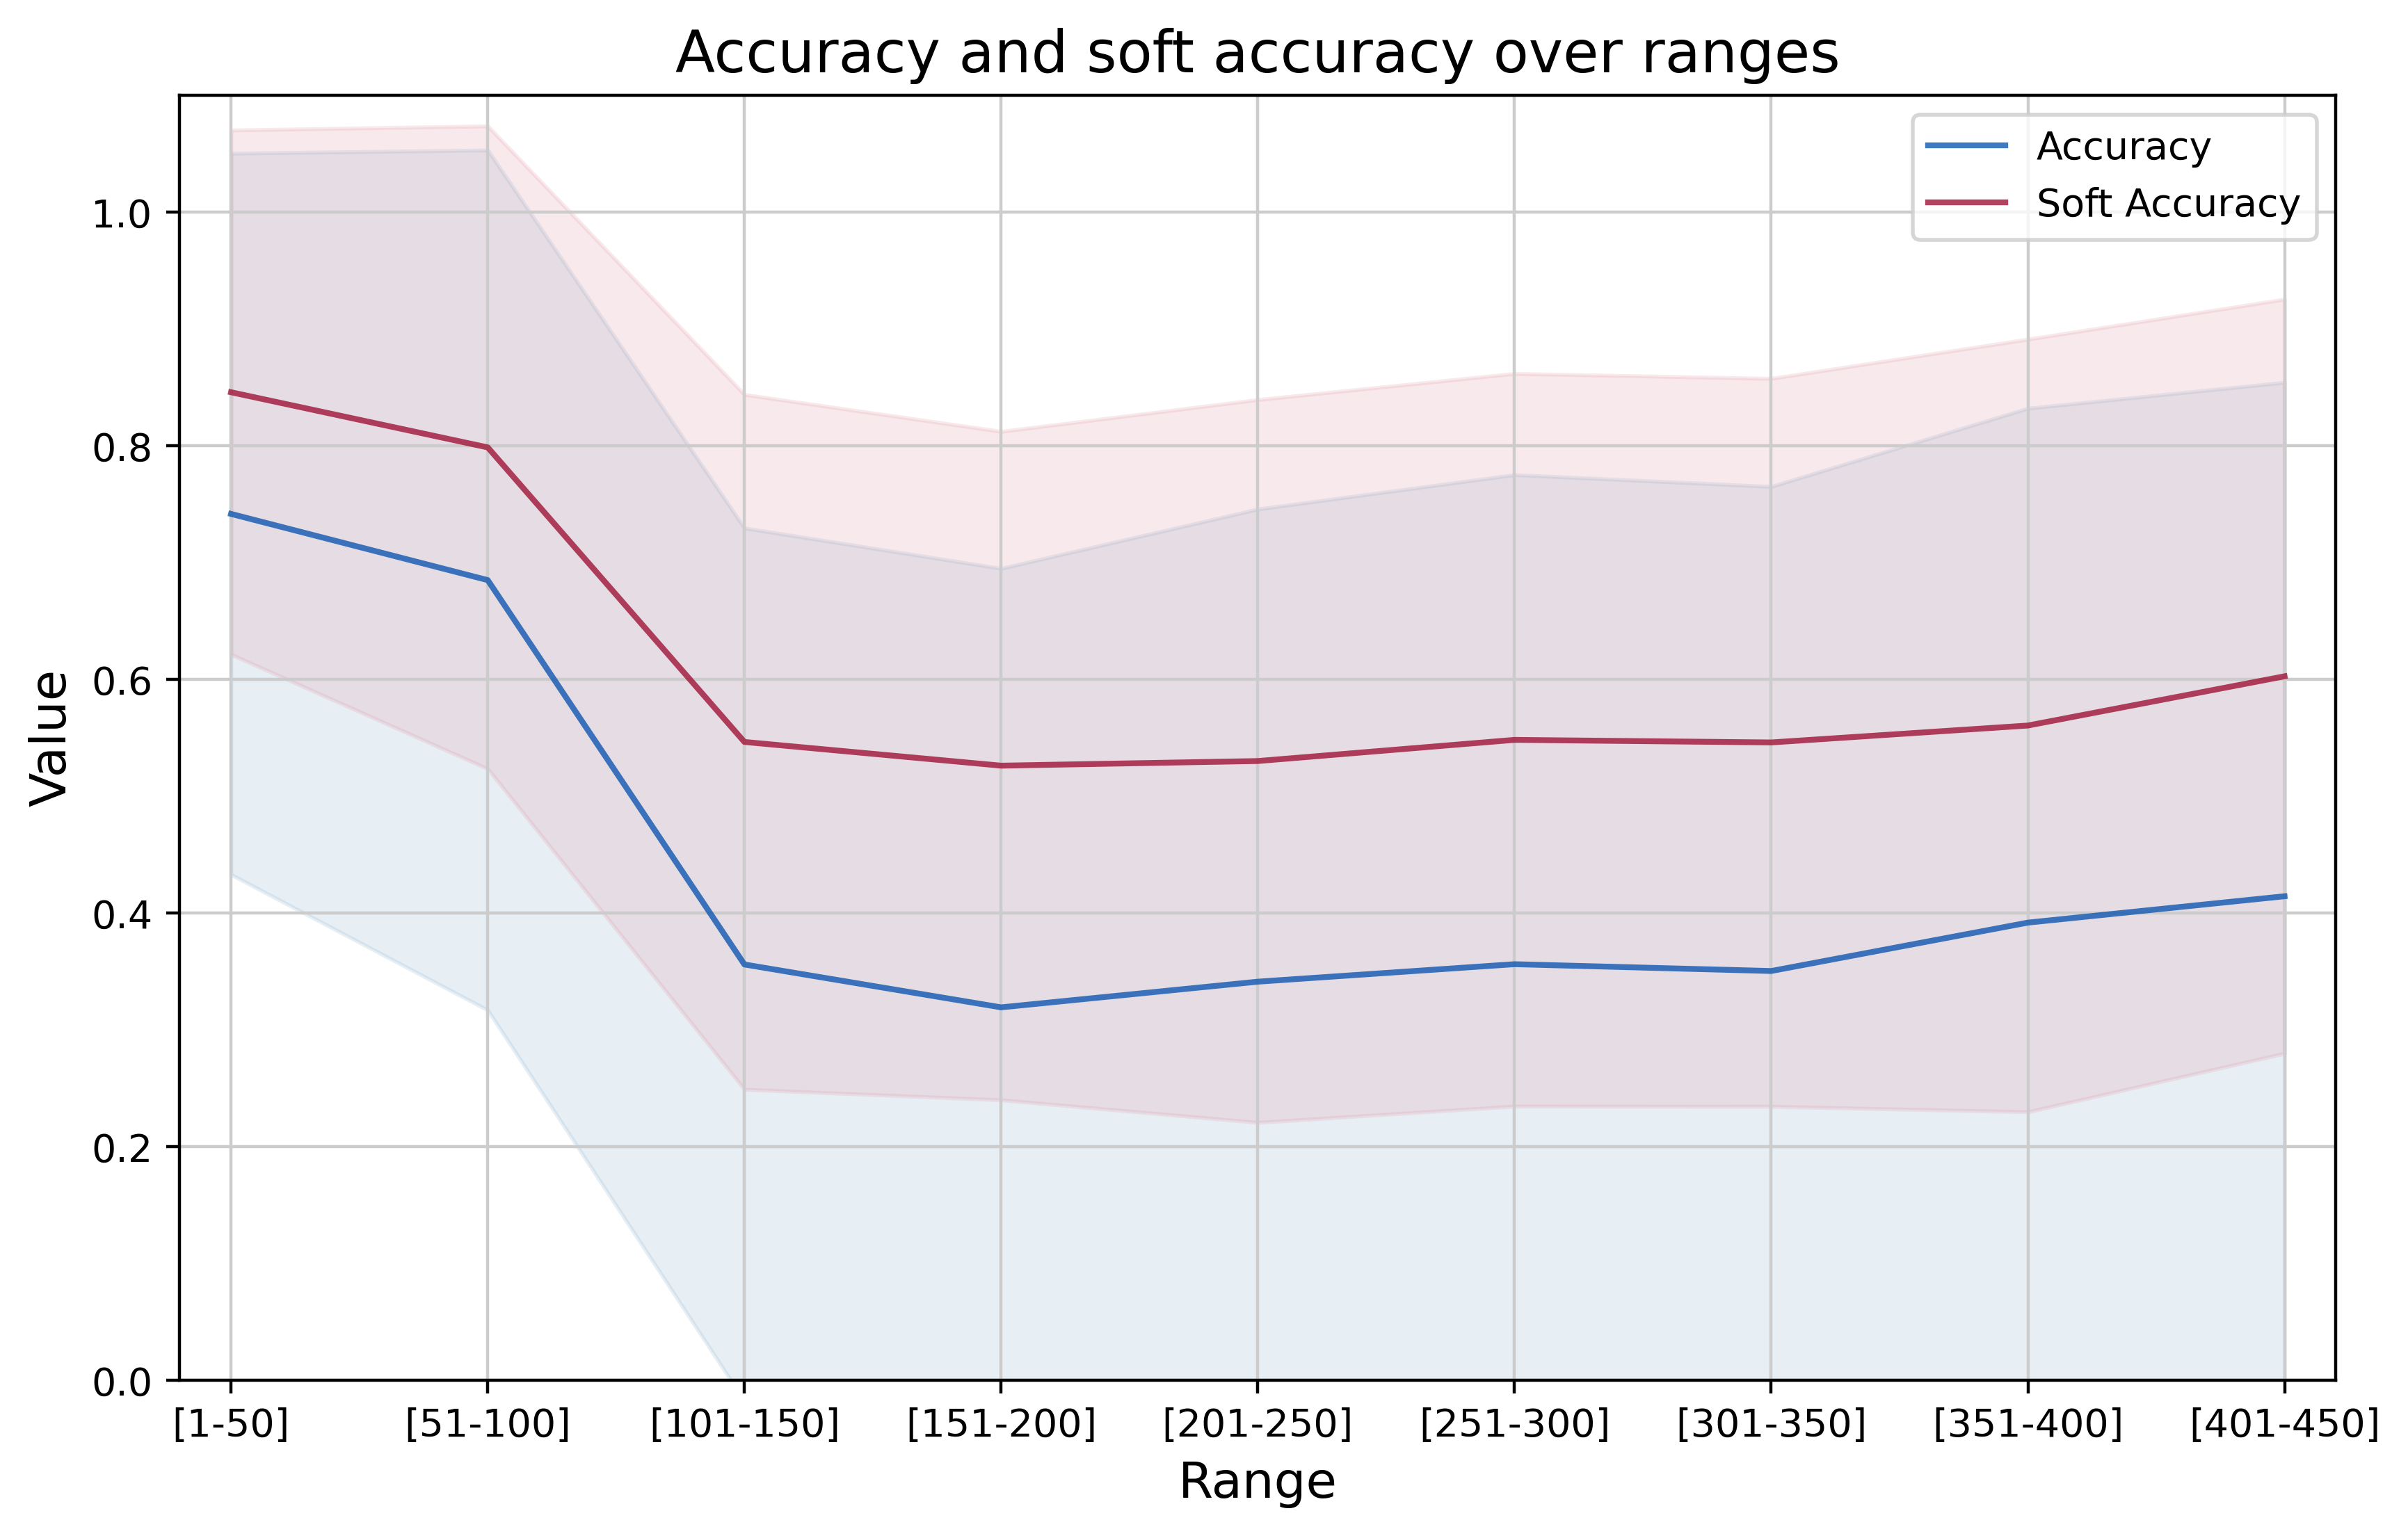

In [40]:
res_names = {}
res_names_512 = {}
acc_dict = None
soft_acc_dict = None
perp_dict = None
for i in experiments:
    #if i != 'PF00959_generalModel_after_20_proteins_2000_p_0_k_1_key_only_0':
    #    continue
    #if i[0] == 'P':
    #    continue
    #if i[0] != 'P':
    #if i != 'new_random_selection_2000_sequences_p_1.2_topk_3_kw_taxa_yes':
    #    continue
    res_names[i] = []
    res_names_512[i] = []
    print(i + '\n')
    results, results_512, acc_dict, soft_acc_dict, perp_dict = compute_stats(directory_path + i + '/')
    res_names[i].append(results)
    res_names_512[i].append(results_512)
    stats_graphs(acc_dict, soft_acc_dict, perp_dict, i)

PF00959_generalModel_after_50_proteins_2000_p_0_k_1_key_only_0



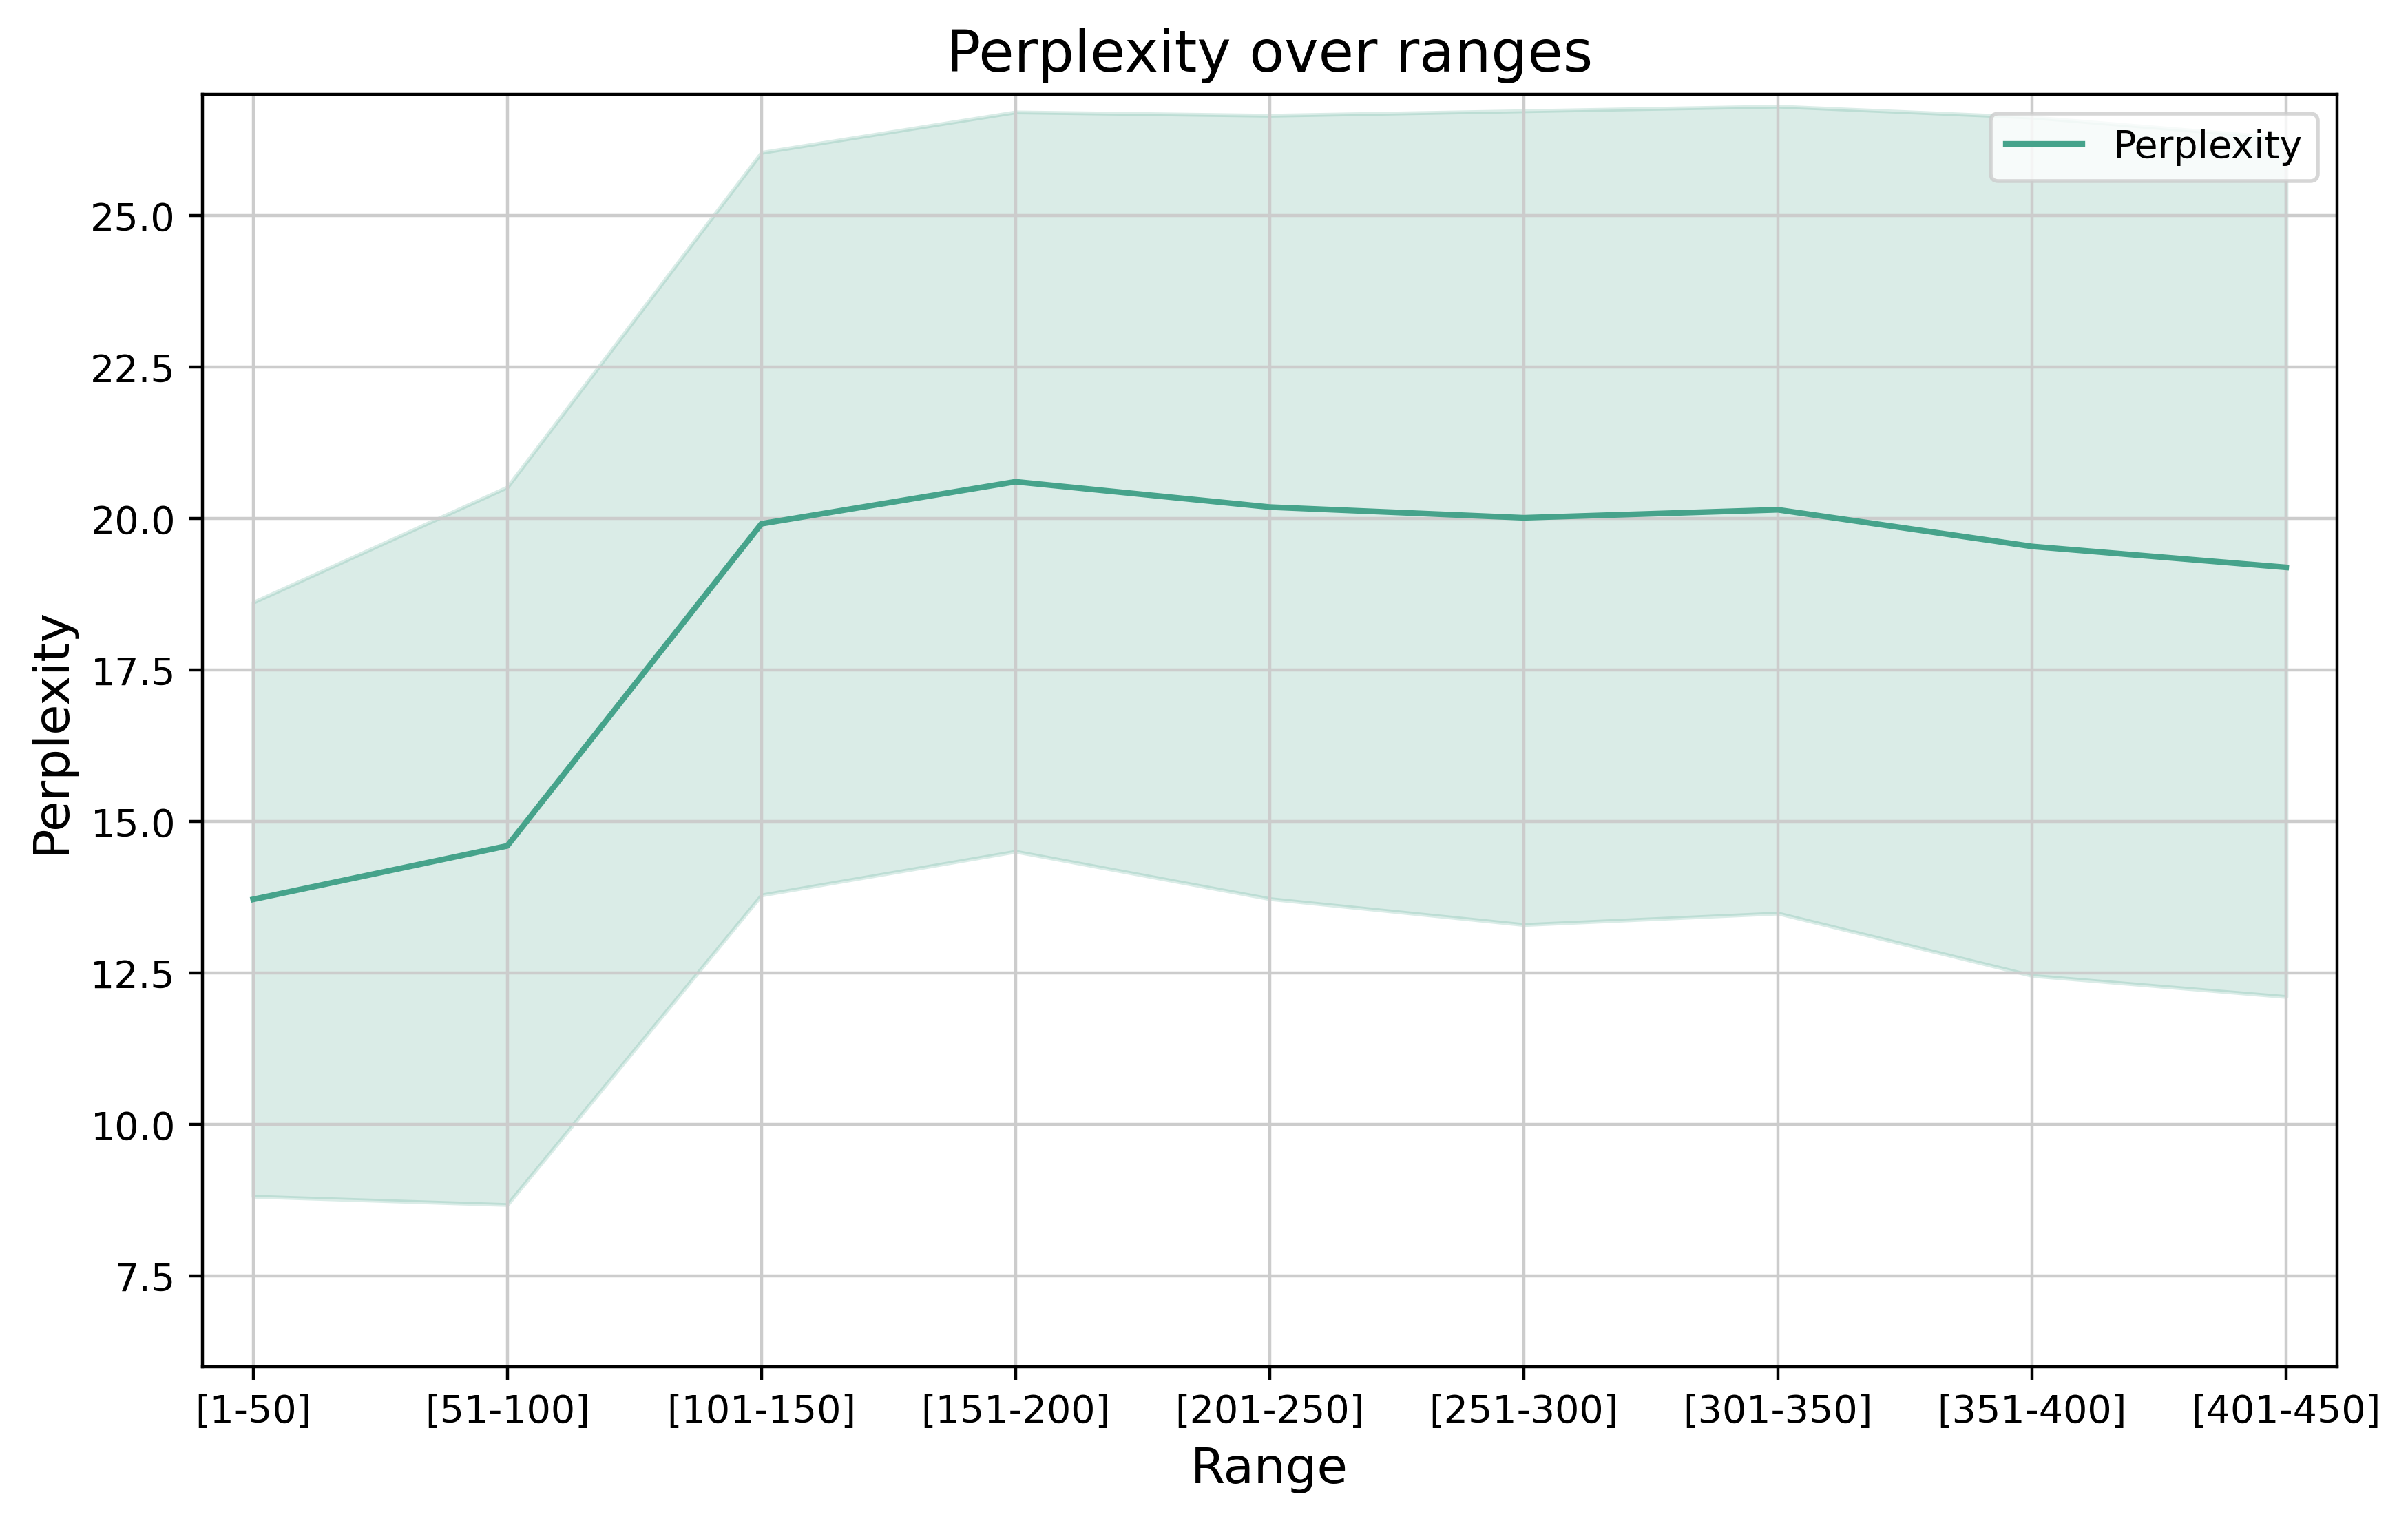

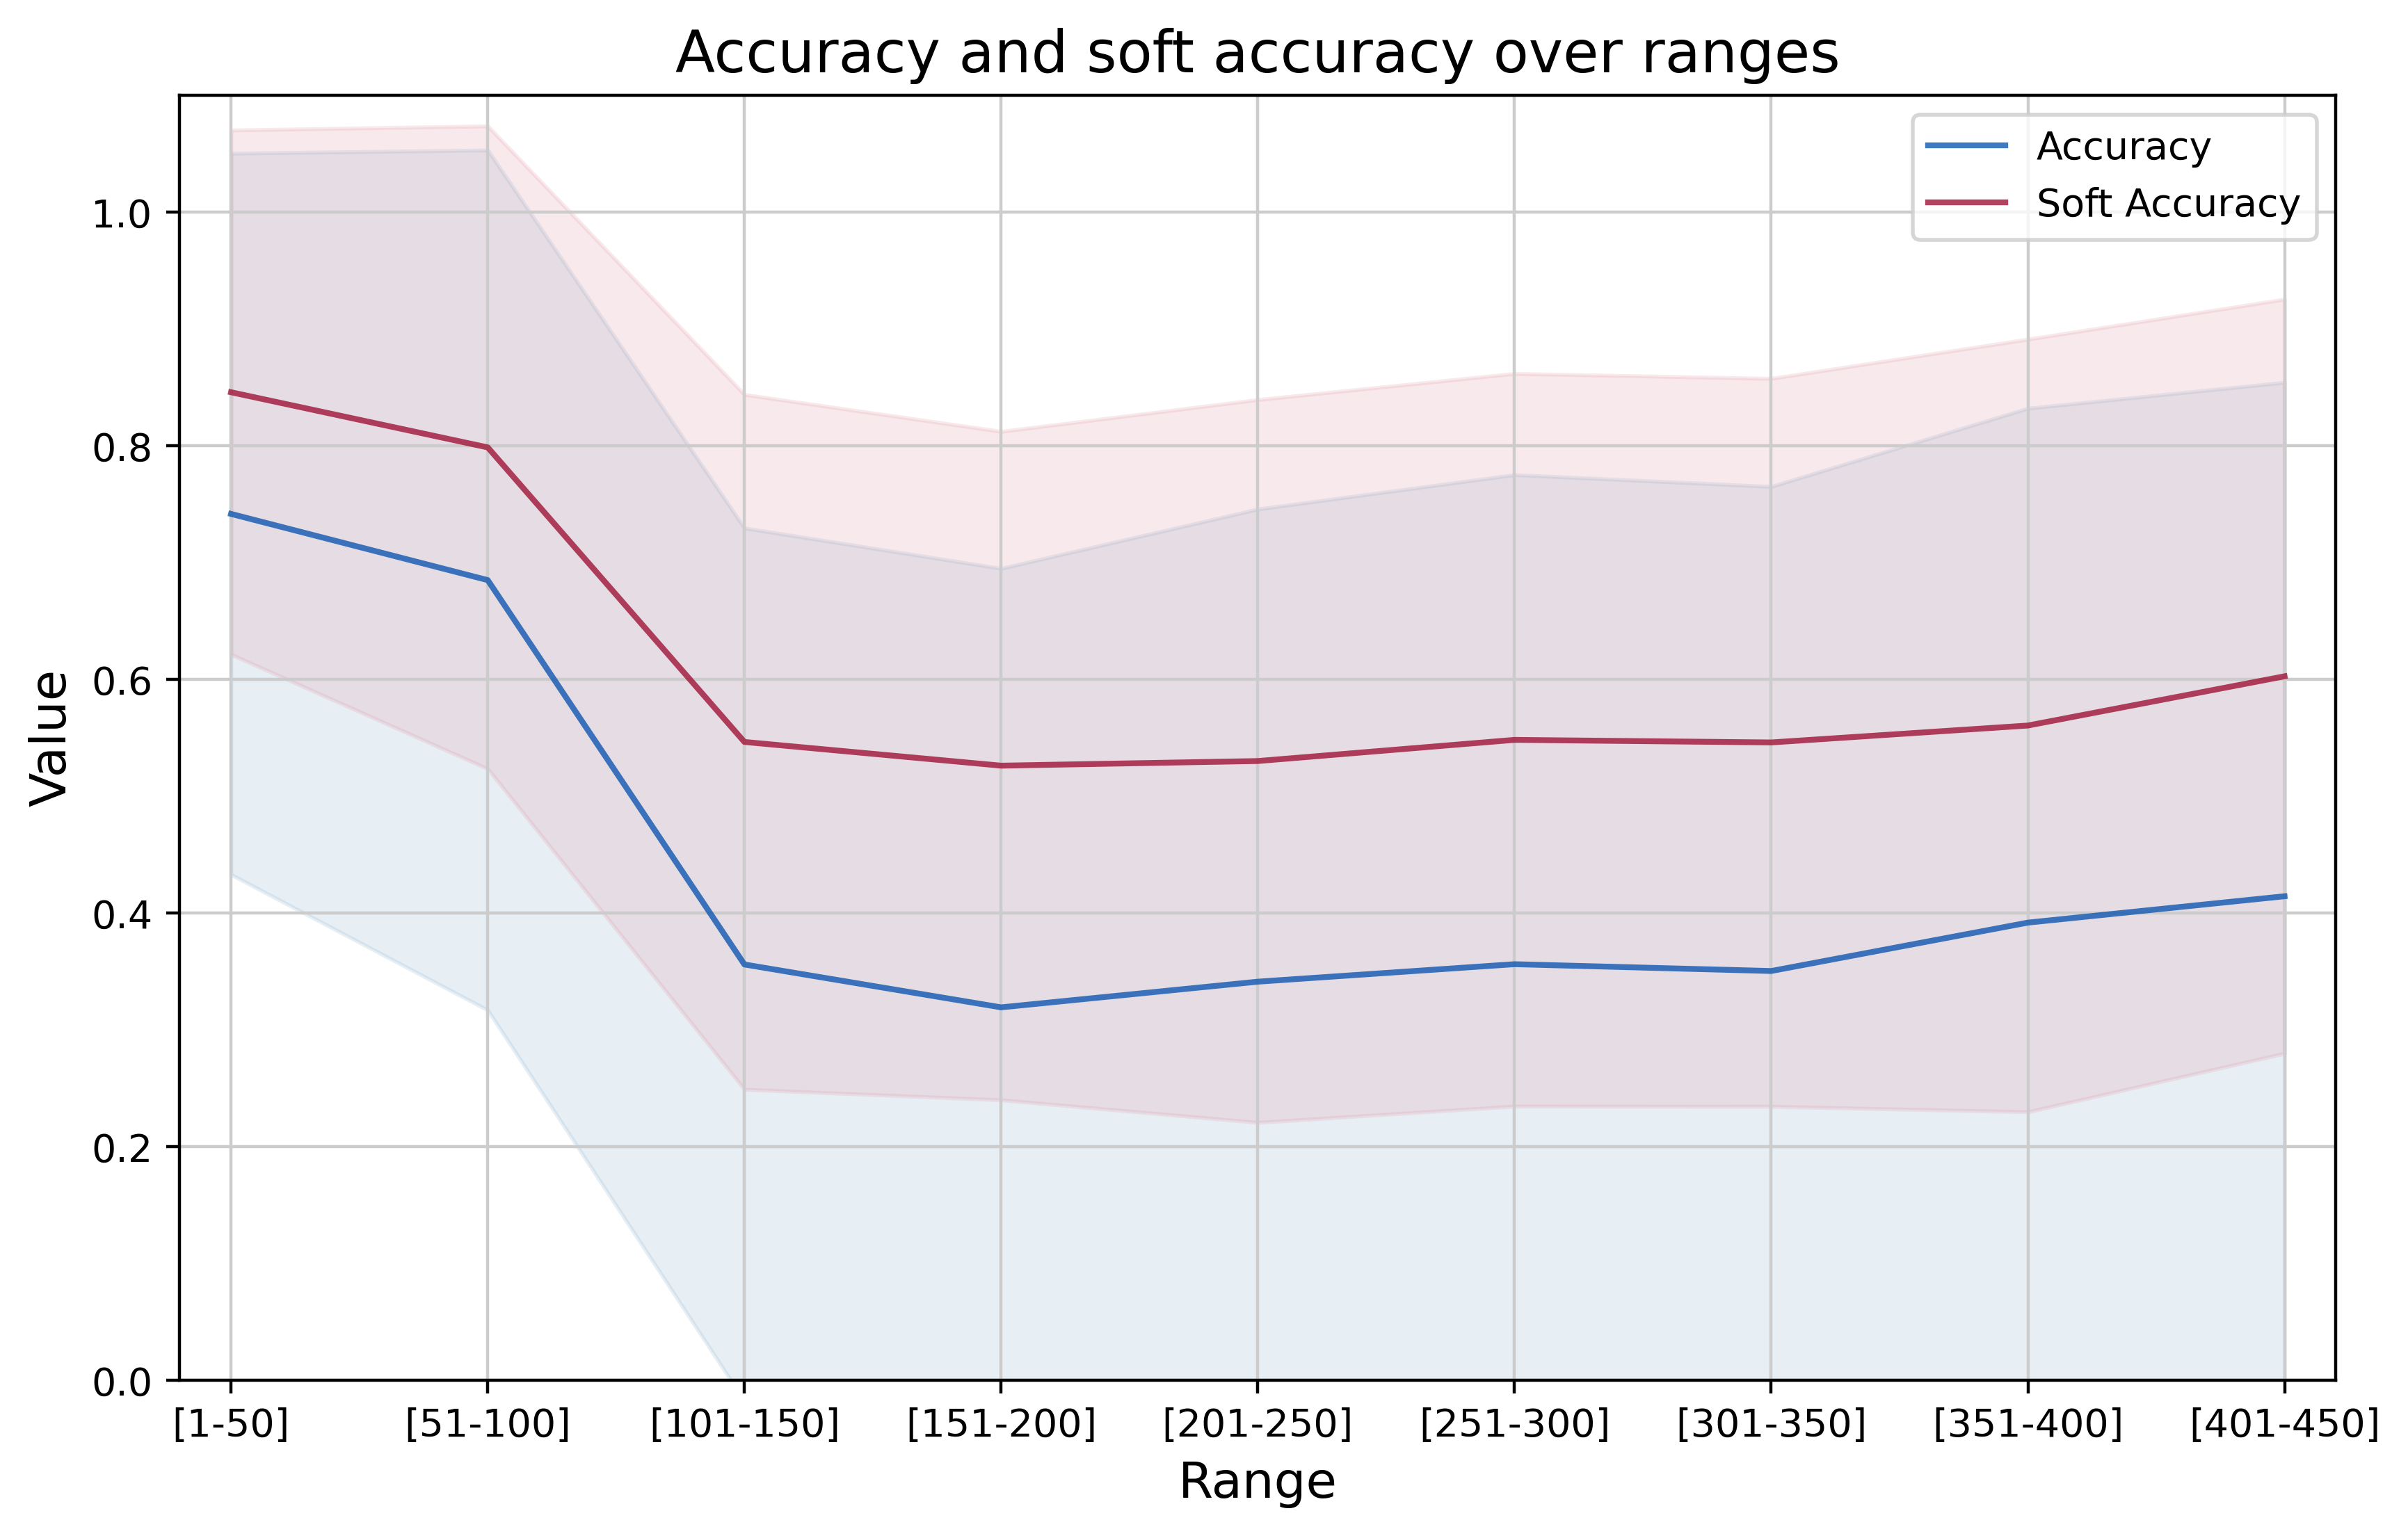

In [33]:
after_training_res_names = {}
after_training_res_names_512 = {}
acc_dict_after_t = None
soft_acc_dict_after_t = None
perp_dict_after_t = None
for i in after_training_experiments:
    #if i != 'PF00959_after_20_TRAINING_4_2000_p_0_k_1_key_only_0':
    #    continue
    after_training_res_names[i] = []
    after_training_res_names_512[i] = []
    print(i + '\n')
    file_directory = directory_path + i + '/'
    results, results_512, acc_dict_after_t, soft_acc_dict_after_t, perp_dict_after_t = compute_stats(file_directory)
    after_training_res_names[i].append(results)
    after_training_res_names_512[i].append(results_512)
    stats_graphs(acc_dict_after_t, soft_acc_dict_after_t, perp_dict_after_t, i)
    

In [34]:
if len(res_names_512) != 1:
    print('Something wrong for stats comparison 1')
if len(after_training_res_names_512) != 1:
    print('Something wrong for stats comparison 2')

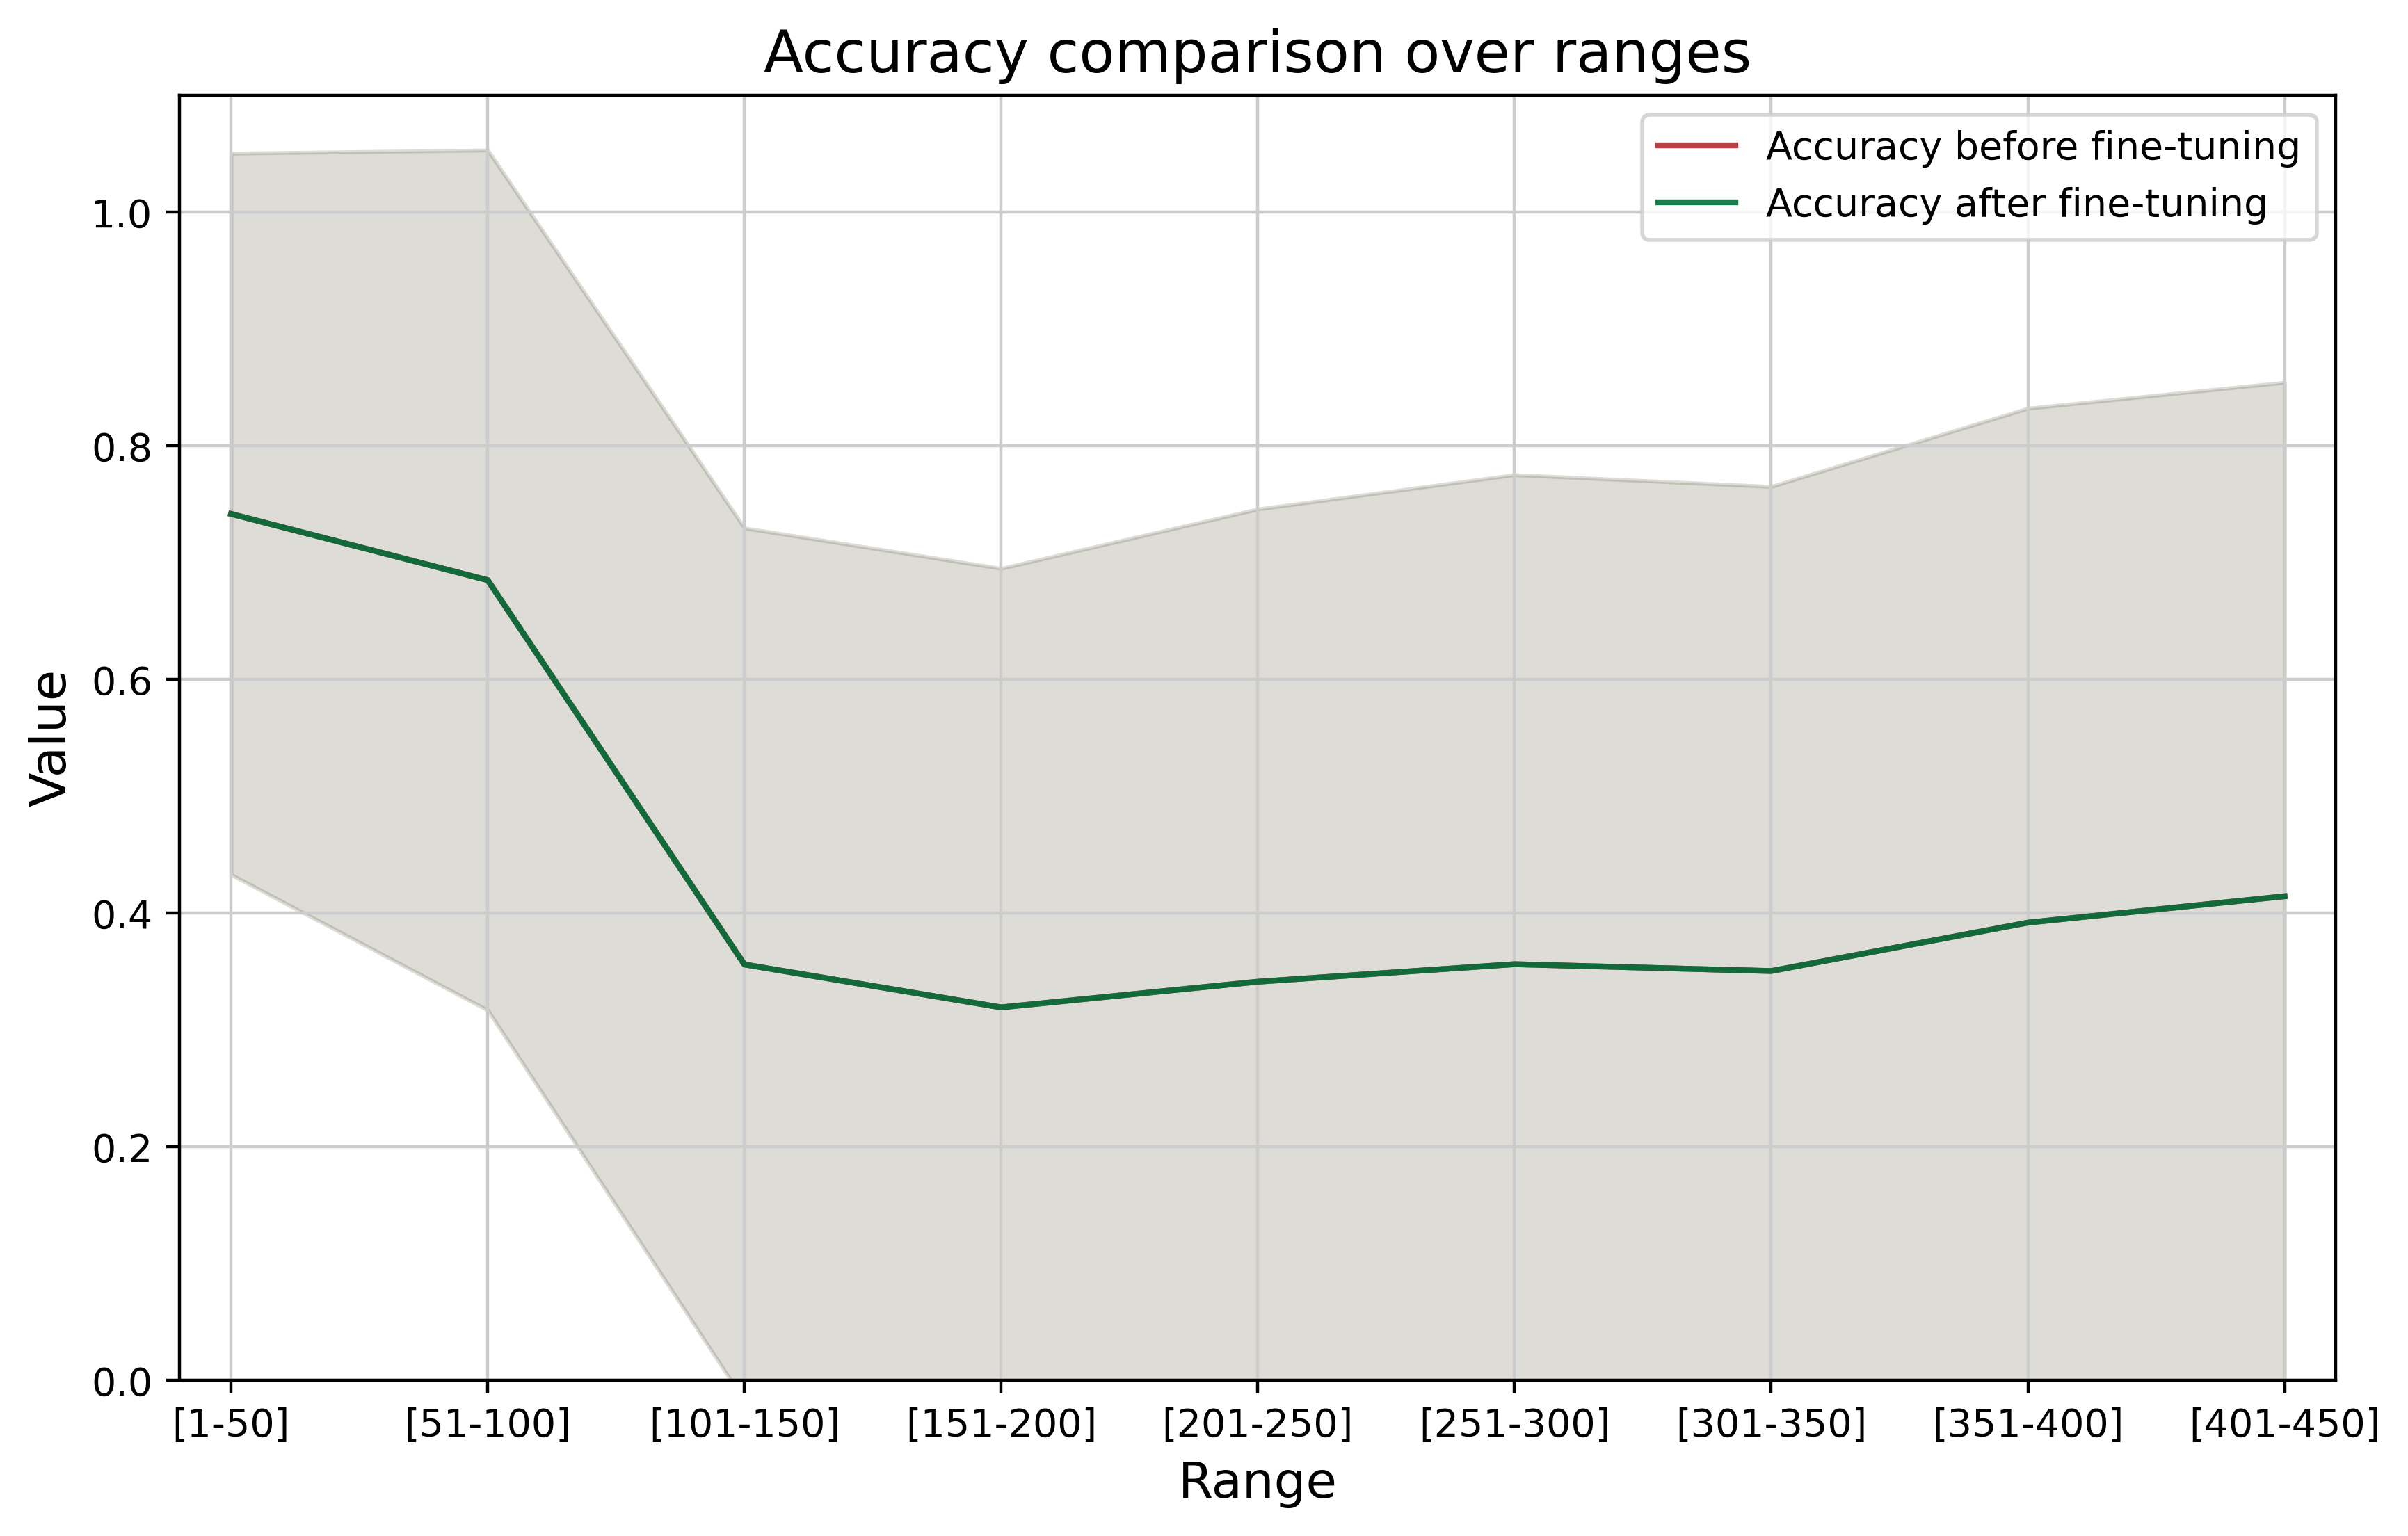

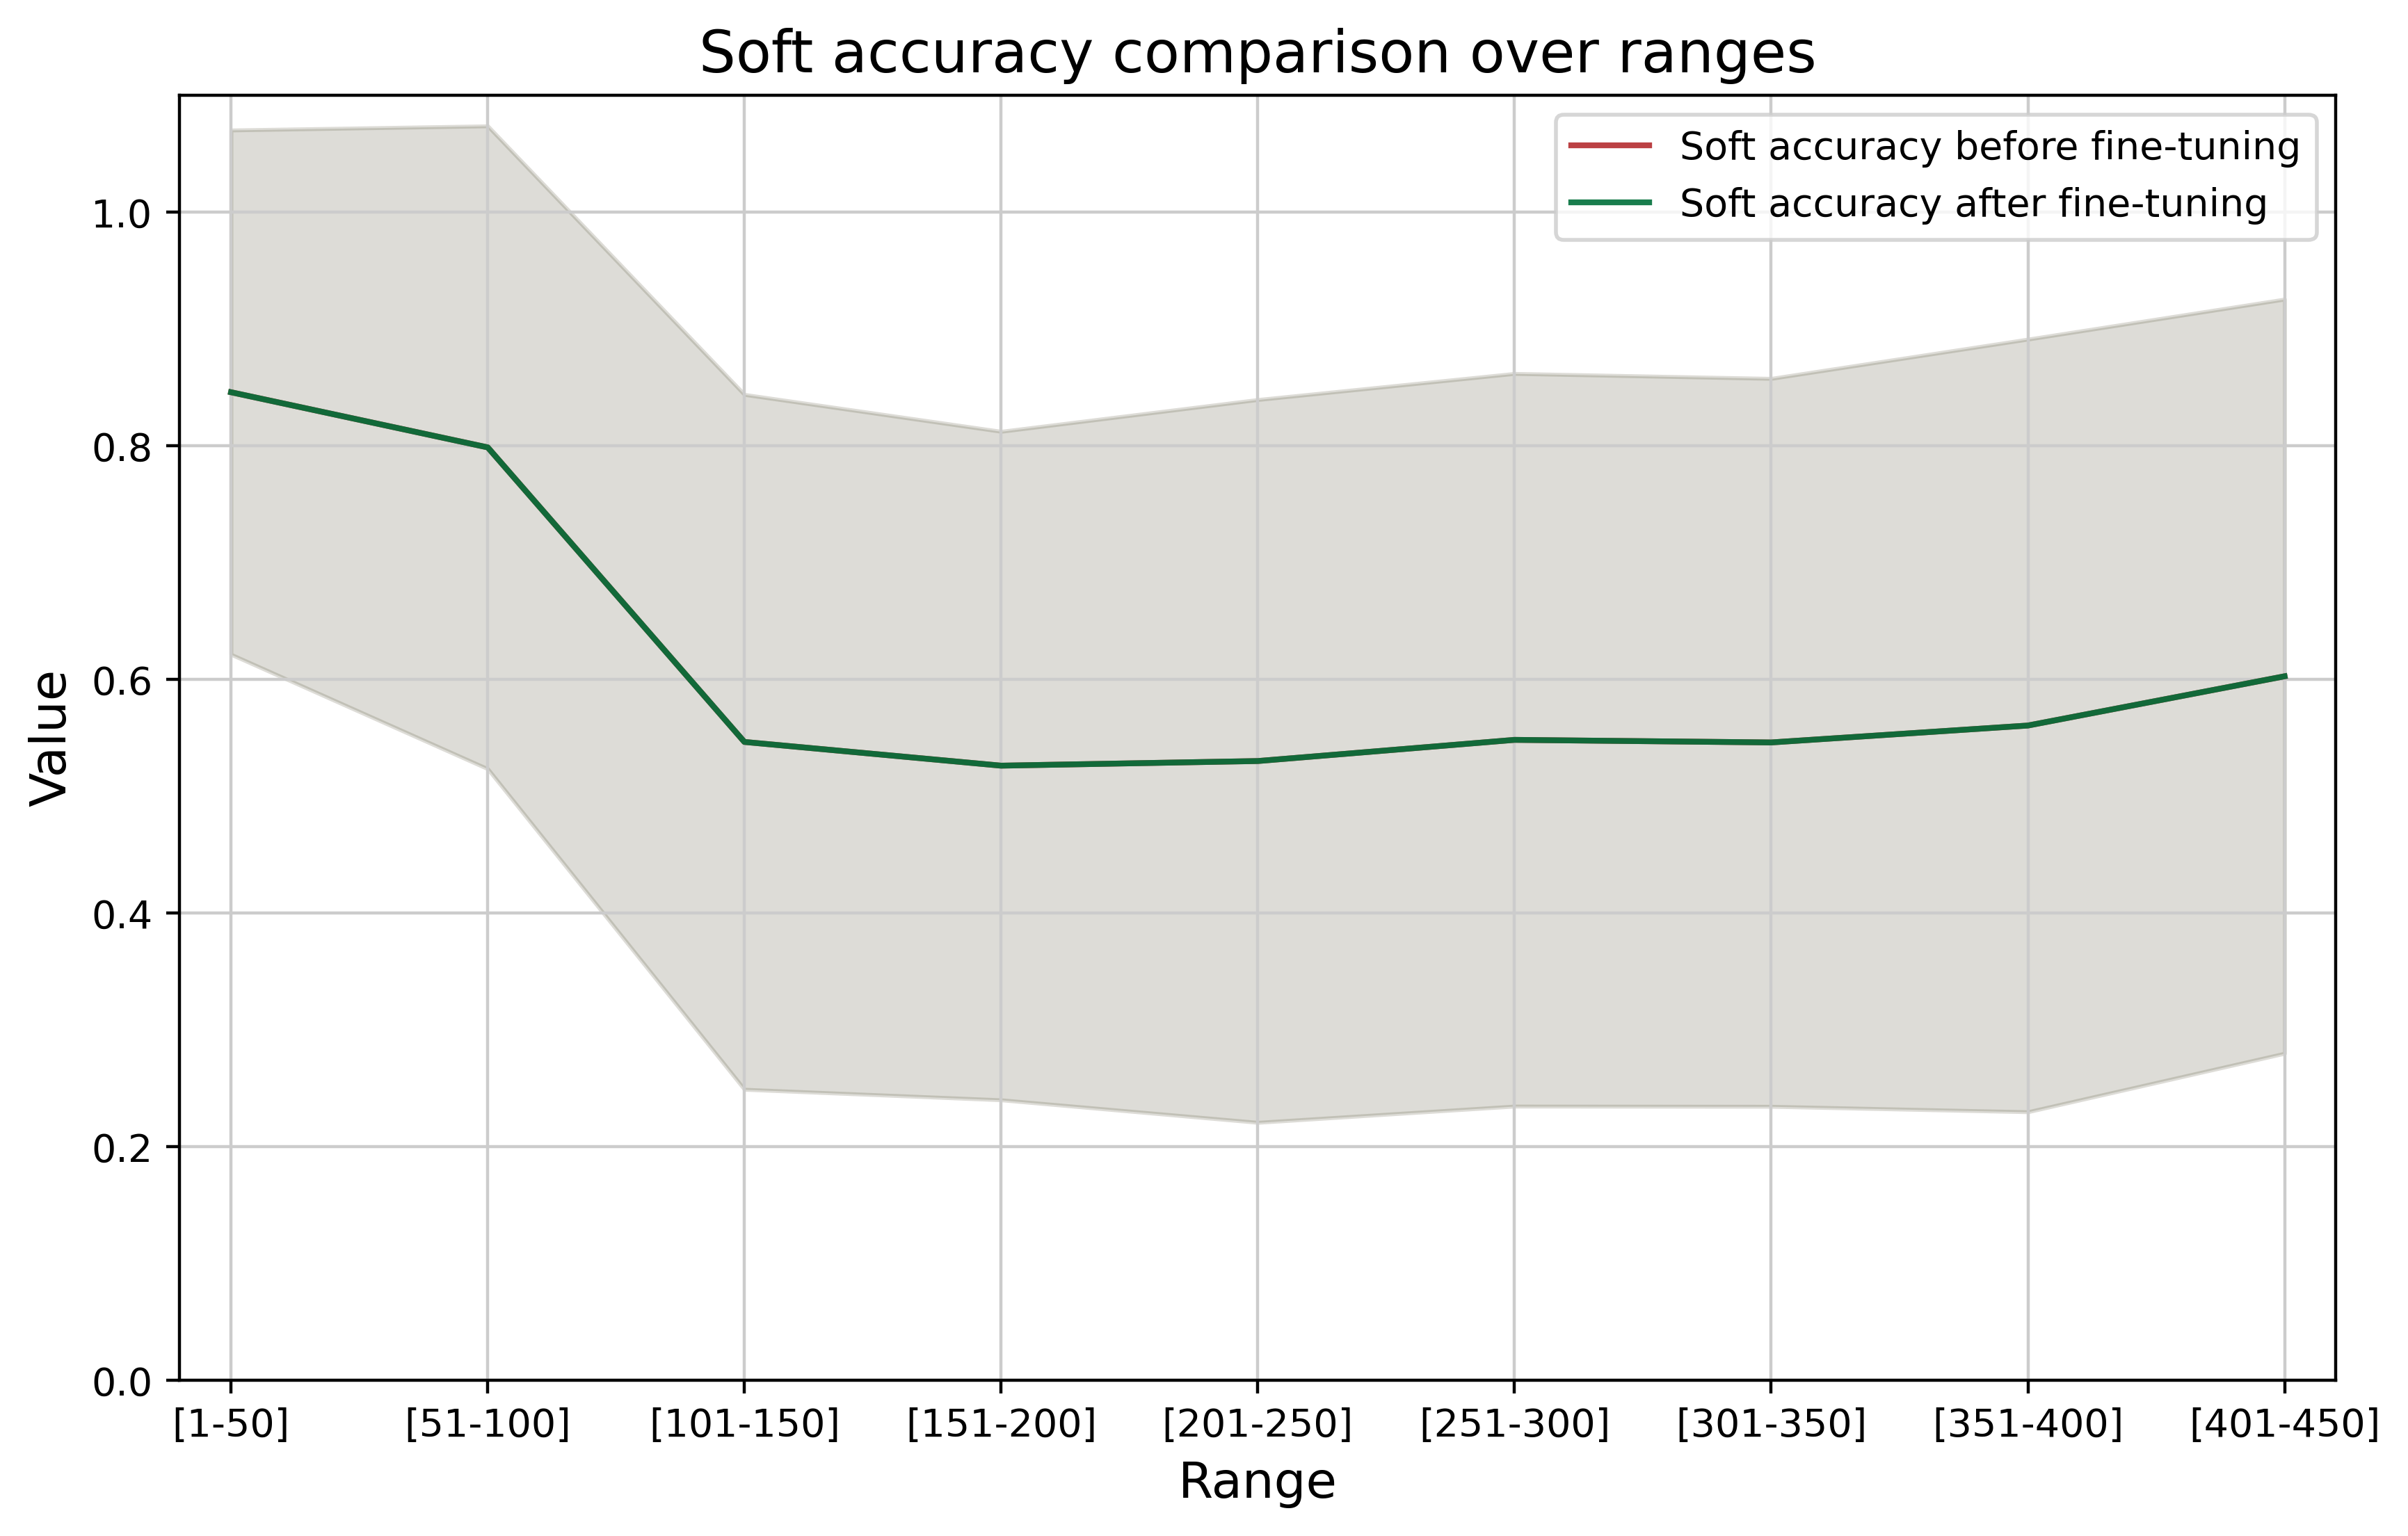

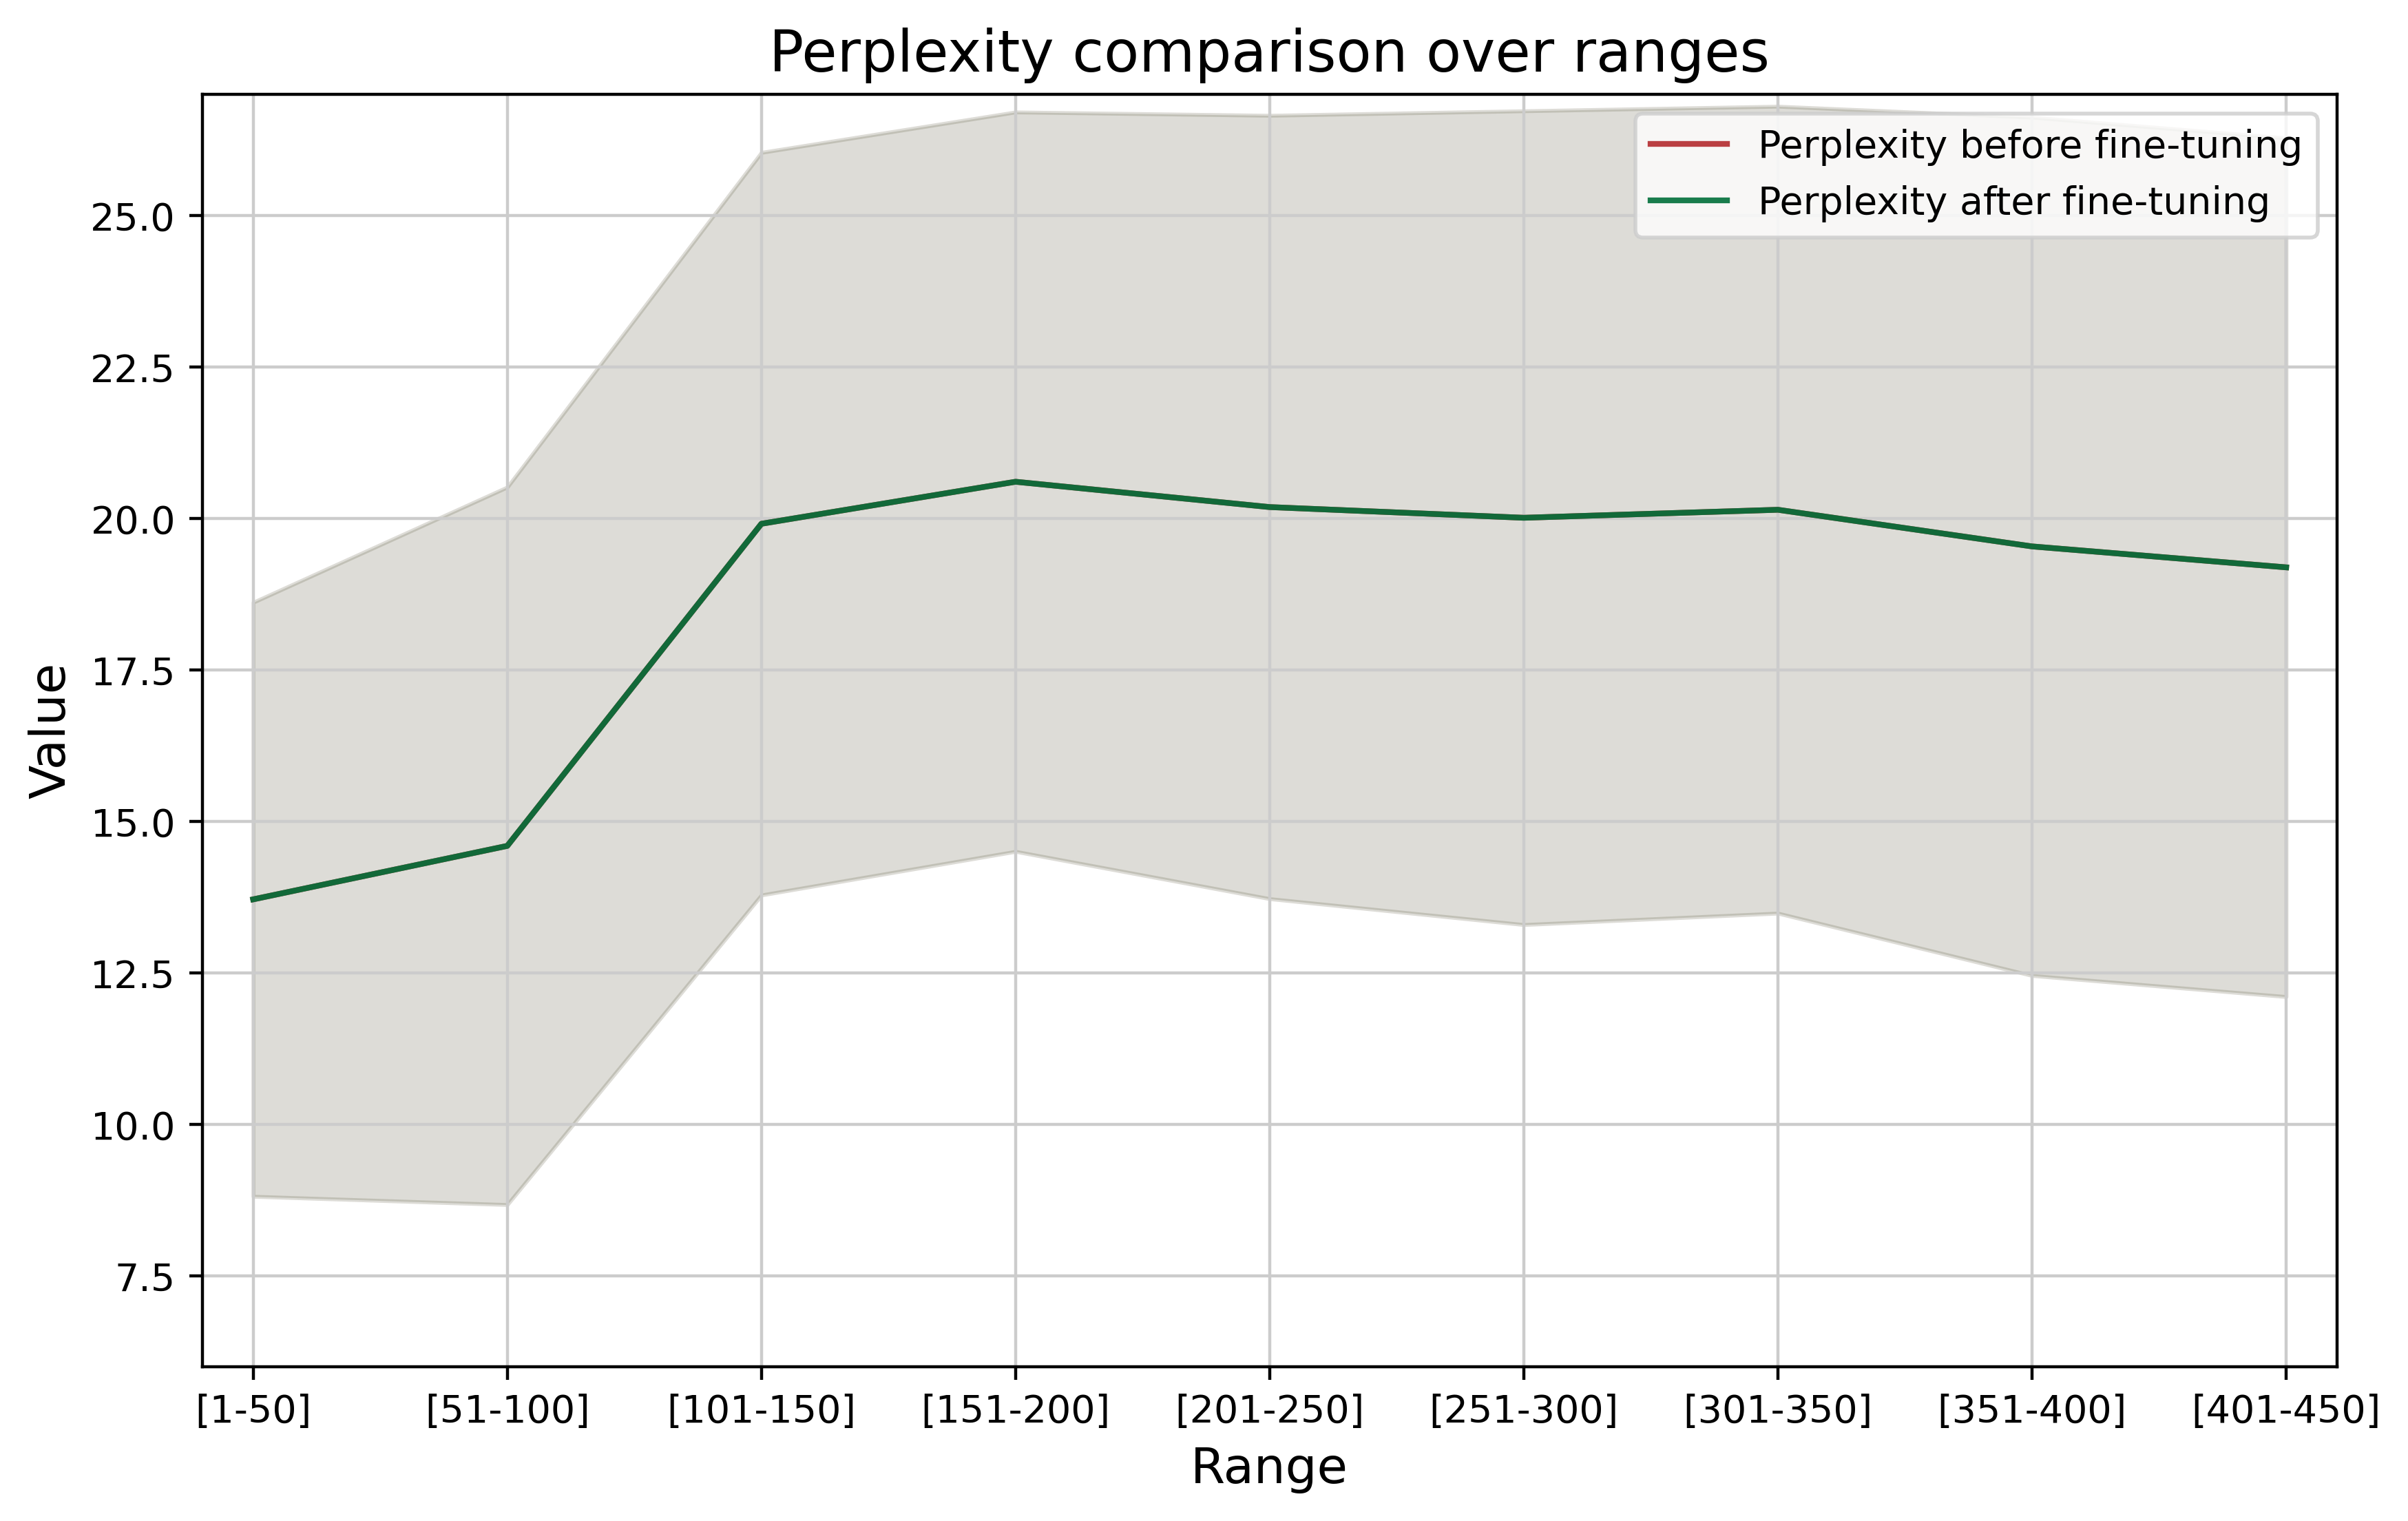

In [39]:
stats_graphs_comparison(acc_dict, soft_acc_dict, perp_dict, acc_dict_after_t, soft_acc_dict_after_t, perp_dict_after_t)

In [35]:
print("\\begin{table}[]")
print("\\label{tab:labellllll}")
print("\\begin{tabular}{|l|l|l|l|l|l|l|}")
print("\\hline")
print("\\textbf{Test size} & $p$ & $k$ & \\textbf{Kw} & & \\textbf{Accuracy} & \\textbf{Soft accuracy} & \\textbf{Perplexity} \\\\ \\hline")
for key in res_names:
    print(key, res_names[key][0], " \\\\ \\hline")
print("\\end{tabular}")
print("\\caption{caption...}")
print("\\end{table}")

\begin{table}[]
\label{tab:labellllll}
\begin{tabular}{|l|l|l|l|l|l|l|}
\hline
\textbf{Test size} & $p$ & $k$ & \textbf{Kw} & & \textbf{Accuracy} & \textbf{Soft accuracy} & \textbf{Perplexity} \\ \hline
PF00959_generalModel_after_50_proteins_2000_p_0_k_1_key_only_0  & $68.1$/$34.008$ & $79.764$/$24.984$ & $14.549$/$5.368$   \\ \hline
\end{tabular}
\caption{caption...}
\end{table}


In [36]:
print("\\begin{table}[]")
print("\\label{tab:labellllll}")
print("\\begin{tabular}{|l|l|l|l|l|l|l|}")
print("\\hline")
print("\\textbf{Test size} & $p$ & $k$ & \\textbf{Kw} & & \\textbf{Accuracy} & \\textbf{Soft accuracy} & \\textbf{Perplexity} \\\\ \\hline")
for key in res_names_512:
    print(key, res_names_512[key][0], " \\\\ \\hline")
print("\\end{tabular}")
print("\\caption{caption...}")
print("\\end{table}")

\begin{table}[]
\label{tab:labellllll}
\begin{tabular}{|l|l|l|l|l|l|l|}
\hline
\textbf{Test size} & $p$ & $k$ & \textbf{Kw} & & \textbf{Accuracy} & \textbf{Soft accuracy} & \textbf{Perplexity} \\ \hline
PF00959_generalModel_after_50_proteins_2000_p_0_k_1_key_only_0  & $68.1$/$34.0$ & $79.764$/$24.977$ & $14.549$/$5.368$   \\ \hline
\end{tabular}
\caption{caption...}
\end{table}


In [37]:
print("\\begin{table}[]")
print("\\label{tab:labellllll}")
print("\\begin{tabular}{|l|l|l|l|l|l|l|}")
print("\\hline")
print("\\textbf{Test size} & $p$ & $k$ & \\textbf{Kw} & & \\textbf{Accuracy} & \\textbf{Soft accuracy} & \\textbf{Perplexity} \\\\ \\hline")
for key in after_training_res_names:
    print(key, after_training_res_names[key][0], " \\\\ \\hline")
print("\\end{tabular}")
print("\\caption{caption...}")
print("\\end{table}")

\begin{table}[]
\label{tab:labellllll}
\begin{tabular}{|l|l|l|l|l|l|l|}
\hline
\textbf{Test size} & $p$ & $k$ & \textbf{Kw} & & \textbf{Accuracy} & \textbf{Soft accuracy} & \textbf{Perplexity} \\ \hline
PF00959_generalModel_after_50_proteins_2000_p_0_k_1_key_only_0  & $68.1$/$34.008$ & $79.764$/$24.984$ & $14.549$/$5.368$   \\ \hline
\end{tabular}
\caption{caption...}
\end{table}


In [38]:
print("\\begin{table}[]")
print("\\label{tab:labellllll}")
print("\\begin{tabular}{|l|l|l|l|l|l|l|}")
print("\\hline")
print("\\textbf{Test size} & $p$ & $k$ & \\textbf{Kw} & & \\textbf{Accuracy} & \\textbf{Soft accuracy} & \\textbf{Perplexity} \\\\ \\hline")
for key in after_training_res_names_512:
    print(key, after_training_res_names_512[key][0], " \\\\ \\hline")
print("\\end{tabular}")
print("\\caption{caption...}")
print("\\end{table}")

\begin{table}[]
\label{tab:labellllll}
\begin{tabular}{|l|l|l|l|l|l|l|}
\hline
\textbf{Test size} & $p$ & $k$ & \textbf{Kw} & & \textbf{Accuracy} & \textbf{Soft accuracy} & \textbf{Perplexity} \\ \hline
PF00959_generalModel_after_50_proteins_2000_p_0_k_1_key_only_0  & $68.1$/$34.0$ & $79.764$/$24.977$ & $14.549$/$5.368$   \\ \hline
\end{tabular}
\caption{caption...}
\end{table}


<h3>Code to make understand and debug</h3>

In [ ]:
# DEVELOPMENT
# Example usage of perplexity computation
probs_all = [[[[0.3, 0.7]], [[0.6, 0.4]]], [[[0.2, 0.8]], [[0.5, 0.5]]]]
indexes_all = [[[0], [1]], [[1], [0]]]

perplexity = compute_perplexities(probs_all, indexes_all)
print("perplexity:", perplexity)


In [ ]:
# DEVELOPMENT
# Example usage of hard and soft accuracy computation
true_sequences =      ['LS', 'LLPL', 'OOOOOOO'] # List of true sequences MITIMMNFHN
predicted_sequences = ['MS', 'OOOO', 'ASSSSSS']  # List of predicted sequences

# Compute hard accuracy
accuracy = compute_all_hard_accuracies(true_sequences, predicted_sequences)

# Compute soft accuracy
soft_accuracy = compute_soft_accuracies(true_sequences, predicted_sequences)

print("Accuracy:", accuracy, "\nSoft accuracy:", soft_accuracy)